# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

1. Risk profile of streets = https://wdl-data.fra1.digitaloceanspaces.com/pse/m_risk_prfile.zip
2. Excel explaining the categorical features : https://wdl-data.fra1.digitaloceanspaces.com/pse/Dictionary_Risk_Profiles.xlsx
2. OSM map = https://download.bbbike.org/osm/extract/planet_-9.89,38.265_-8.309,39.136.osm.pbf

## Introduction


When it comes to road safety, Portugal has one of the less impressive records in Europe, however, authorities have been taking steps in an attempt to improve the statistics; with fatalities dropping by 40% since 2010. Despite this, more than 400 people lost their lives in 2017 in road accidents and more than 40,000 injured.

An **European report** underlined these characteristics: 
- In Portugal, relatively many moped riders, lorry and truck occupants died in road accidents compared to the EU average.
- Portugal has a somewhat higher share of male road fatalities than the EU average.
- Fatalities in built-up areas, during daylight and while raining are overrepresented in Portugal.
- The number of speed tickets per population in Portugal is much lower than the EU average

Furthermore from our analysis we could see that there are three environments that where the pavement properties significantly, yet distinctly, influence the occurrence of accidents:

1. Rural environment with a heavy presence of urban characteristics
2. Environment characterized by a considerable predominance of intersections in a rural environment
3. Environment with curved segments, high longitudinal gradients and **average speed higher than the tolerable speed**




**HYPHOTHESIS** :


## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

### IMPORTING PACKAGES

In [1]:
# GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# LOADING DATA
import requests
import os
import shutil
from io import BytesIO
import osmium
import fiona
import json


# GEOSPATIAL DATA
from shapely.geometry import Point, LineString, MultiPoint
from shapely.geometry import shape 


# PLOTTING DATA
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.features import ColorLine, GeoJsonPopup, GeoJsonTooltip
from folium.map import FeatureGroup
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns

# STATS
import math
import stats

# ML
import scipy
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

### Extracting data

We decide to start clean and analyses the dataset given by the ***WDL*** team: a shape file containing 34678 different road segments. Each of these road segments is characterized by information on traffic intensity, velocity and environment in which this is inserted. 

In [5]:
def first_df(path):
    geo = gpd.read_file(path)
    df = pd.DataFrame(geo).drop(columns='Link_ID')
    df_ren = df.rename(columns={
                        'Daily_Aver':'Daily_Average_Traffic_Intensity',
                        'Average_Ve':'Average_Velocity_of_Vehicle_Traffic',
                        'Median_of_':'Median_of_velocity_of_Vehicle_Traffic',
                        'First_Quar': 'FirstQuartil_of_velocity_of_Vehicle_Traffic',
                        'Third_Quar': 'ThirdQuartil_of_velocity_of_Vehicle_Traffic'
                    })
    return df_ren
    
df = first_df('wdl_data/m_risk_prfile.geojson') 

To have a better understanding on our data and to avoid errors during our analysis we need to investigate it with general statistics.
To be able to trust our analysis we have to clean the dataset before. 

### Remove outliers: 

In [6]:
df.describe()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.816834,56.463409,43.822041,68.091844,2.684613,4.904781
std,2.355910e+08,2725.873982,51.983670,26.240876,24.442204,30.985191,0.538658,1.520568
min,8.021682e+07,14.435864,-401.703724,1.000000,-392.500000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.315321,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.966126,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.511585,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,6357.022296,1326.250000,143.000000,2605.000000,3.000000,7.000000


- Regarding the columns we know that they report values in km/h: many of the min and max we can observe thank to describe function don't make sense. 
- We need to operate on them as they are **outliers**

In [7]:
#removing outliers:
def rm_out(df):
    for i in df.columns.drop(['linkid', 'Daily_Average_Traffic_Intensity','geometry']):
        lb = 0
        ub = 180
#         print(lb, ub)
        df[i] = df[i].mask(df[i] < lb) 
        df[i] = df[i].mask(df[i] > ub) 
    return df

data = rm_out(df)

**If we run describe again we will see that the data regarding velocity has just feasible values.**

In [8]:
data.describe()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34633.000000,34675.000000,34677.000000,34674.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.112805,56.402803,43.834624,67.959767,2.684613,4.904781
std,2.355910e+08,2725.873982,24.346245,25.054113,24.329987,26.706718,0.538658,1.520568
min,8.021682e+07,14.435864,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.317003,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.961538,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.447459,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,179.691892,143.250000,143.000000,164.000000,3.000000,7.000000


### Handling duplicates:

In [9]:
len(data) == len(data.drop_duplicates())

True

There are ***no duplicates*** in our dataset: NO ACTION NEEDED
    

### Handling missing values:

In [10]:
data.isnull().sum().sort_values(ascending=False) , f'Total of data points : {data.shape[0]}'

(Average_Velocity_of_Vehicle_Traffic            45
 ThirdQuartil_of_velocity_of_Vehicle_Traffic     4
 Median_of_velocity_of_Vehicle_Traffic           3
 FirstQuartil_of_velocity_of_Vehicle_Traffic     1
 linkid                                          0
 Daily_Average_Traffic_Intensity                 0
 Func_Class                                      0
 Speed_Cat                                       0
 geometry                                        0
 dtype: int64,
 'Total of data points : 34678')

As we can see the total highest number of missing values detected for column is 45 on a total number of rows of 34'678.
- The missing value for Average Velocity e the ones in Speed Difference Mean are the same (one column is created from the other one)
- The missing values of other column can be easily deleted

**As we are handling data regarding AVERAGE velocity we can easily substitute the missing values with the mean of the corresponding column**

In [12]:
def handling_missing(data):
    imputer = SimpleImputer()
    data['Average_Velocity_of_Vehicle_Traffic']=imputer.fit_transform(data[['Average_Velocity_of_Vehicle_Traffic']])
    return data.dropna()
data = handling_missing(data)

In [13]:
data.isnull().sum()

linkid                                         0
Daily_Average_Traffic_Intensity                0
Average_Velocity_of_Vehicle_Traffic            0
Median_of_velocity_of_Vehicle_Traffic          0
FirstQuartil_of_velocity_of_Vehicle_Traffic    0
ThirdQuartil_of_velocity_of_Vehicle_Traffic    0
Func_Class                                     0
Speed_Cat                                      0
geometry                                       0
dtype: int64

### Feature creation:

Now looking at our data we need to search for a target that in the next step we will use in our model.
Most common causes of Accidents:
- Over Speeding.
- Drunken Driving.
- Distractions to Driver.
- Red Light Jumping.
- Avoiding Safety Gears like Seat belts and Helmets.
- Non-adherence to lane driving and overtaking in a wrong manner.

The first cause is always the **over-speed** that can be connected with one of the above causes. 
For this reason we decide to investigate and use as target information regarding the velocity.

- Speed_Cat (described in the excel below)
- Average Velocity of Vehicle Traffic 
- Median of velocity of Vehicle Traffic

We will create a dictionary that, from the information contained in the excel can describe the type of street regarding the max velocity allowed in there.

In [14]:
speed_explanation = pd.read_excel('wdl_dict/Dictionary_Risk_Profiles.xlsx', sheet_name='SpeedCat')
speed_explanation

,Speed Cat,Speed range in km/h
0,1,>130 km/h
1,2,101-130 km/h
2,3,91-100 km/h
3,4,71-90 km/h
4,5,51-70 km/h
5,6,31-50 km/h
6,7,11-30 km/h
7,8,<11 km/h


from the table above we can create a dictionary.
1. count values for category
2. translate the speed range in actual number

In [15]:
data.Speed_Cat.value_counts()

6    20307
4     5273
2     5123
3     1843
5     1770
7      357
Name: Speed_Cat, dtype: int64

**NO need of mapping for label 1 and 8**

In [17]:
max_speed_dict = {2:130,3:100,4:90,5:70,6:50,7:30}
def target_creation(data):
    data['Max_speed'] = data['Speed_Cat'].map(max_speed_dict)
    data['Speed_Diff_Mean'] = data['Max_speed'] - data['Average_Velocity_of_Vehicle_Traffic']
    data['Speed_Diff_Median'] = data['Max_speed'] - data['Median_of_velocity_of_Vehicle_Traffic']
    return data
data = target_creation(data)

<ipython-input-17-97c7211f1675>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Max_speed'] = data['Speed_Cat'].map(max_speed_dict)
<ipython-input-17-97c7211f1675>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Speed_Diff_Mean'] = data['Max_speed'] - data['Average_Velocity_of_Vehicle_Traffic']
<ipython-input-17-97c7211f1675>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

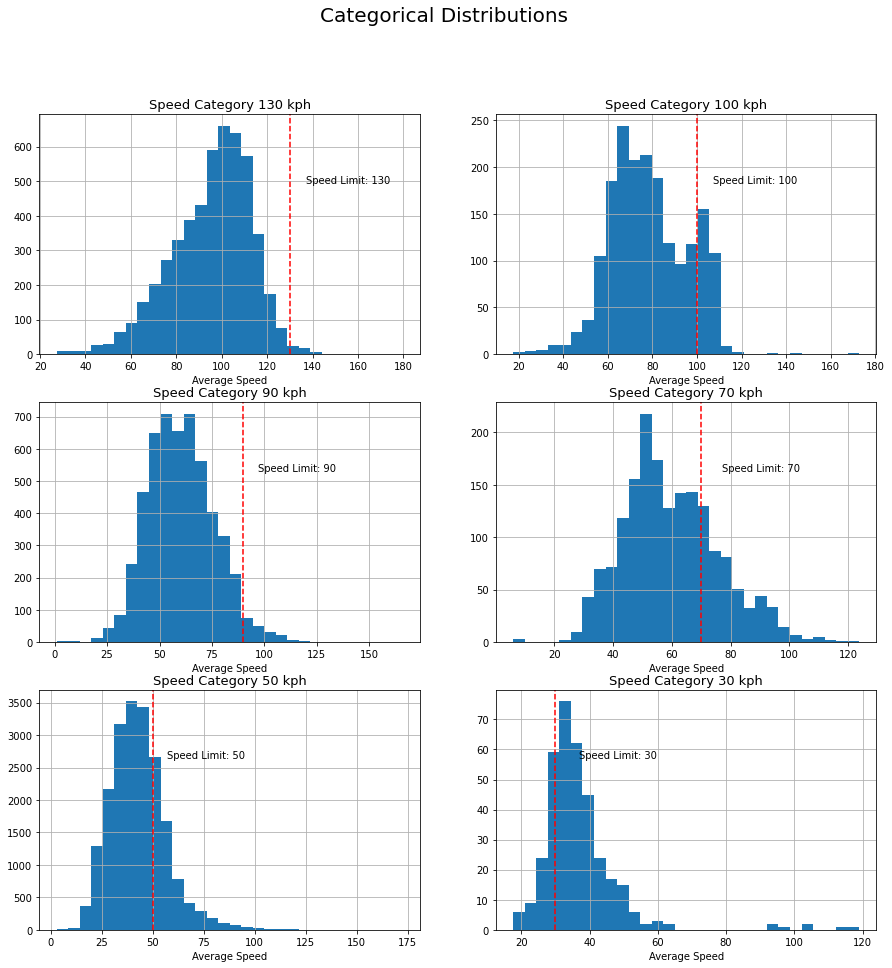

In [41]:
cat_list = {x:data[data['Max_speed']==x] for x in max_speed_dict.values()}
def speed_dist(cat_list):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Categorical Distributions', size=20)
#     fig.tight_layout()
    for c, i in enumerate(cat_list.items()):
        speedlim = i[0]
        plt.subplot(3, 2, c+1)
#         plt.set_xlabel('Average Speed')
        ax = i[1].Average_Velocity_of_Vehicle_Traffic.hist(bins=30)
        ylim = i[1].Average_Velocity_of_Vehicle_Traffic.value_counts(bins=30).max()
        ax.set_title(f'Speed Category {i[0]} kph', size=13)
        ax.set_xlabel('Average Speed')
        ax.axvline(speedlim, color='r', linestyle='--')
#         print(f'done {speedlim}, {ylim/2}, {speedlim}')
        ax.text(x=speedlim+7, y=float(ylim-ylim/4), s=f'Speed Limit: {speedlim}')
        
speed_dist(cat_list)

*Note*<br>
We can see that most over speeding is taking place at roads with lower speed limits such as *50 kph and 30 kph.*

**Over speeding behavior can be extracted by the deltas between the road's speed category and its actual average speed observations**

In [18]:
data[['Speed_Cat','Max_speed', 'Speed_Diff_Mean','Speed_Diff_Median']].head(10)

,Speed_Cat,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,6,50,4.791284,5.535714
1,4,90,10.436692,7.250000
2,6,50,-15.955069,-17.333333
3,6,50,2.466089,6.000000
4,6,50,-1.375291,-3.250000
5,6,50,17.667821,18.333333
6,6,50,19.613591,22.937500
7,6,50,26.714286,39.000000
8,6,50,6.476409,4.000000
9,6,50,-11.897045,1.346154


We believe that the main reason that is able to decrease the safety of a street is the speed rate.
**Our first target will be the difference between the mean of velocity and the max speed**

### Scaling features:

We are now ready to scale our dataframe to have a distribution *around* the mean.

1. We need to separate numerical and categorical column
2. We are going to use the Min-Max Scaling method for the numerical ones: is the one that is commonly used distance based algorithms, as k-means that is one of the possible analysis we are taking in consideration.  
3. For the categorical ones we'll use the OneHotEncoding method (for each label in each category creates a different column)

We could also operate this step all together but is important for us to know which column belong to each of the different classes inside the categorical feature. 
**To do so we need to operate for each categorical separately**

In [23]:
def scaling_numerical(data):
    numerical = data.columns.drop(['geometry','linkid','Speed_Cat', 'Func_Class'])
    scaler = MinMaxScaler()
    data_scaled = data.copy()
    for column in numerical:
        scaler.fit(data_scaled[[column]])
        data_scaled[column]=scaler.transform(data_scaled[[column]]) 
    return data_scaled
data_scaled = scaling_numerical(data)

1. **BEFORE SCALING**

In [24]:
data.drop(columns=['geometry','linkid','Speed_Cat', 'Func_Class']).head(1)

,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,6224.778569,45.208716,44.464286,28.0,59.0,50,4.791284,5.535714


2. **AFTER SCALING**

In [25]:
data_scaled.drop(columns=['geometry','linkid','Speed_Cat', 'Func_Class']).head(1)

,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,0.125982,0.247402,0.305549,0.195804,0.355828,0.2,0.565472,0.502626


**Working with the categorical features the first thing we need to do is to understand the distribution within the labels**

In [26]:
data.Func_Class.value_counts() , data.Speed_Cat.value_counts()

(3    25023
 2     8363
 1     1287
 Name: Func_Class, dtype: int64,
 6    20307
 4     5273
 2     5123
 3     1843
 5     1770
 7      357
 Name: Speed_Cat, dtype: int64)

- Functional Class has just 3 possible label for the street that we can understand better looking at the excel

In [27]:
func_explanation = pd.read_excel('wdl_dict/Dictionary_Risk_Profiles.xlsx', sheet_name='Func_Class')
for i,el in enumerate(func_explanation['Description']):
    print(f'Class n.{i+1} : {el} \n')

Class n.1 : These roads are meant for high volume, maximum speed traffic between and through major metropolitan areas. There are very few, if any, speed changes. Access to this road is usually controlled. 

Class n.2 : These roads are used to channel traffic to Main Roads (FRC1) for travel between and through cities in the shortest amount of time. There are very few, if any speed changes. 

Class n.3 : These roads interconnect First Class Roads (FRC2) and provide a high volume of traffic movement at a lower level of mobility than First Class Roads (FRC2). 



With this new and deeper understanding of the distribution and the meaning of the category (*NB: regarding speed_cat we can look back at the point **1.1.5 "Feature creation"** to get these informations)* we can now progress with our transformations.  

In [28]:
def scaling_categorical(data):
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(data[['Func_Class']])
    func_encoded = ohe.transform(data[['Func_Class']])
    data["func_1"],data["func_2"],data['func_3'] = func_encoded.T
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(data[['Speed_Cat']])
    speed_encoded = ohe.transform(data[['Speed_Cat']])
    data["speed_2"],data["speed_3"],data["speed_4"],\
    data["speed_5"], data["speed_6"], data["speed_7"]= speed_encoded.T
    return data 

In [29]:
data_scaled = scaling_categorical(data_scaled)

### Preprocessed Dataframe: 

Here we have the first dataframe, the one given by the challenge, completely ready for the model.

In [33]:
data_scaled.head()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,geometry,Max_speed,...,Speed_Diff_Median,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7
0,80216819,0.125982,0.247402,0.305549,0.195804,0.355828,2,6,"MULTILINESTRING ((-9.16402 38.77030, -9.16389 ...",0.2,...,0.502626,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,80216858,0.045067,0.439658,0.574692,0.501748,0.565951,2,4,"MULTILINESTRING ((-9.16645 38.74274, -9.16638 ...",0.6,...,0.511029,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,80216859,0.043093,0.363503,0.466315,0.426573,0.453988,3,6,"MULTILINESTRING ((-9.16645 38.74274, -9.16637 ...",0.2,...,0.390523,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,80216860,0.044363,0.260414,0.302285,0.188112,0.447853,3,6,"MULTILINESTRING ((-9.16588 38.74370, -9.16568 ...",0.2,...,0.504902,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,80216867,0.042360,0.281911,0.367311,0.317016,0.355828,3,6,"MULTILINESTRING ((-9.16472 38.74478, -9.16487 ...",0.2,...,0.459559,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature engineering

We assume that ***over speeding*** is the main reason for road hazards. Over speeding behavior can be extracted by the deltas between the road's speed category and its actual average speed observations as processed in column ```Speed_Diff_Mean```. <br>

Over speeding can be harnessed among others by the roads environment [Source](https://www.tandfonline.com/doi/abs/10.1080/014416499295420). People chose their speeding behavior not only by speed limits but also by their assessment of the road's quality and the surrounding environment.<br>

Therefore we chose to gather more information about POIs, amenities and public buildings in the surrounding of the provided road segments. Those can be acquired through OSM sources.

### Scaling data set to Lisbon

waiting expl sisto

In [34]:
# Transforming pandas df to geopandas df
geo_df = gpd.GeoDataFrame(data_scaled)
geo_df.geometry[0].type

'MultiLineString'

In [35]:
## Filtering only lisbon data inside the circle of 38.72526068747401, -9.142352617846093 with buffer '1'
circle_lisbon = Point(-9.142352617846093, 38.72526068747401).buffer(1)
geo_lis = geo_df[geo_df.geometry.within(circle_lisbon)]
# no immediate usage of this pd.DataFrame
df_lis = pd.DataFrame(geo_lis).drop(columns=['geometry', 'linkid'])

In [36]:
print(f'The new data set has {df_lis.shape[0]} rows as opposed to the original set with {geo_df.shape[0]} rows')

The new data set has 17688 rows as opposed to the original set with 34673 rows


### Loading OSM Maps

In [37]:
%%bash
wget https://download.bbbike.org/osm/extract/planet_-9.89,38.265_-8.309,39.136.osm.pbf \
    --quiet -O map_data/Lisbon.osm.pbf

In [38]:
!ogrinfo map_data/Lisbon.osm.pbf

INFO: Open of `map_data/Lisbon.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [39]:
%%bash
ogr2ogr -f "GPKG" \
     map_data/lisbon_polygons.gpkg \
     map_data/Lisbon.osm.pbf \
    -nlt POLYGONS \
    -nln polygons

0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type POINT is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type LINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type MULTILINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver w

In [42]:
#Read data
# about 3 mins
layer_file = "map_data/lisbon_polygons.gpkg"
collection = list(fiona.open(layer_file,'r'))
df1 = pd.DataFrame(collection)

#Check Geometry
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0

df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
df1 = df1[df1['isvalid'] == 1]
collection = json.loads(df1.to_json(orient='records'))

#Convert to geodataframe
gdf_lis_poly = gpd.GeoDataFrame.from_features(collection)

In [44]:
gdf_lis_poly

,geometry,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,...,historic,land_area,landuse,leisure,military,natural,office,shop,sport,tourism
0,POINT (-9.39964 38.95586),20629108,Lapa da Serra,None,None,None,None,None,neighbourhood,None,...,None,None,None,None,None,None,None,None,None,None
1,POINT (-9.41390 38.96183),20629118,None,None,crossing,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,POINT (-9.18832 38.74858),21272086,None,None,crossing,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,POINT (-9.45296 38.75312),21404046,None,None,bus_stop,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,POINT (-9.45655 38.75241),21404049,None,None,bus_stop,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719506,GEOMETRYCOLLECTION EMPTY,12589376,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
719507,GEOMETRYCOLLECTION EMPTY,12589451,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
719508,GEOMETRYCOLLECTION EMPTY,12589452,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
719509,GEOMETRYCOLLECTION EMPTY,12589453,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [45]:
poi_gdf = gdf_lis_poly.copy()

### Loading POIs from pre-processed OSM file

In [47]:
print(f'The data set of POIs in the Lisbon region has {poi_gdf.shape[0]} individual points which can be merged with our data set.' )

The data set of POIs in the Lisbon region has 719511 individual points which can be merged with our data set.


In [48]:
poi_gdf.geometry.type.value_counts()

Polygon               420865
LineString            195623
Point                  99120
GeometryCollection      3261
MultiLineString          642
dtype: int64

***Note***<br>
For now we will only be focussing on the geometrical points in the OSM data, not on polygons or line strings.

In [49]:
# filtering down to shapely.geometry.Points
gdf_points = poi_gdf[poi_gdf['geometry'].type == 'Point'].reset_index()
gdf_points.columns

Index(['index', 'geometry', 'osm_id', 'name', 'barrier', 'highway', 'ref',
       'address', 'is_in', 'place', 'man_made', 'other_tags', 'waterway',
       'aerialway', 'z_order', 'type', 'osm_way_id', 'aeroway', 'amenity',
       'admin_level', 'boundary', 'building', 'craft', 'geological',
       'historic', 'land_area', 'landuse', 'leisure', 'military', 'natural',
       'office', 'shop', 'sport', 'tourism'],
      dtype='object')

**Note**<br>
The points provided are categorized and stored in many columns. We will shrink this information to one column and fill it with all the important information about the point. <br>
Some points do not provide any information. Those ones will be dropped. 

In [50]:
# reducing geo_df columns, only leaving one valid column
def new_desc(geo):
    geo['desc_points'] = None
    # columns to be taken into consideration
    lst_cols = [  'amenity', 
                  'barrier', 
                  'building', 
                  'highway', 
                  'landuse', 
                  'man_made', 
                  'natural', 
                  'office']
    for c, row in geo.iterrows():
#         concat_name = [f'feat_{i}_{row[i]}' for i in lst_cols if row[i] == row[i]]
        concat_name = [f'feat_{i}_{row[i]}' for i in lst_cols if row[i] != None]
        if len(concat_name) > 0:
            geo.at[c, 'desc_points'] = concat_name[0]
        else: 
            geo.at[c, 'desc_points'] = None
        print(f'done: {c}')
        
    
    geo = geo[['geometry', 'desc_points']]
    # drop empty descriptions
    geo = geo.dropna(subset=['desc_points'])
    geo= geo.reset_index(drop=True)
    
    return geo

In [51]:
# applying cleaning function to geo df
gdf_points_clean = new_desc(gdf_points)

done: 0
done: 1
done: 2
done: 3
done: 4
done: 5
done: 6
done: 7
done: 8
done: 9
done: 10
done: 11
done: 12
done: 13
done: 14
done: 15
done: 16
done: 17
done: 18
done: 19
done: 20
done: 21
done: 22
done: 23
done: 24
done: 25
done: 26
done: 27
done: 28
done: 29
done: 30
done: 31
done: 32
done: 33
done: 34
done: 35
done: 36
done: 37
done: 38
done: 39
done: 40
done: 41
done: 42
done: 43
done: 44
done: 45
done: 46
done: 47
done: 48
done: 49
done: 50
done: 51
done: 52
done: 53
done: 54
done: 55
done: 56
done: 57
done: 58
done: 59
done: 60
done: 61
done: 62
done: 63
done: 64
done: 65
done: 66
done: 67
done: 68
done: 69
done: 70
done: 71
done: 72
done: 73
done: 74
done: 75
done: 76
done: 77
done: 78
done: 79
done: 80
done: 81
done: 82
done: 83
done: 84
done: 85
done: 86
done: 87
done: 88
done: 89
done: 90
done: 91
done: 92
done: 93
done: 94
done: 95
done: 96
done: 97
done: 98
done: 99
done: 100
done: 101
done: 102
done: 103
done: 104
done: 105
done: 106
done: 107
done: 108
done: 109
done: 110


done: 1569
done: 1570
done: 1571
done: 1572
done: 1573
done: 1574
done: 1575
done: 1576
done: 1577
done: 1578
done: 1579
done: 1580
done: 1581
done: 1582
done: 1583
done: 1584
done: 1585
done: 1586
done: 1587
done: 1588
done: 1589
done: 1590
done: 1591
done: 1592
done: 1593
done: 1594
done: 1595
done: 1596
done: 1597
done: 1598
done: 1599
done: 1600
done: 1601
done: 1602
done: 1603
done: 1604
done: 1605
done: 1606
done: 1607
done: 1608
done: 1609
done: 1610
done: 1611
done: 1612
done: 1613
done: 1614
done: 1615
done: 1616
done: 1617
done: 1618
done: 1619
done: 1620
done: 1621
done: 1622
done: 1623
done: 1624
done: 1625
done: 1626
done: 1627
done: 1628
done: 1629
done: 1630
done: 1631
done: 1632
done: 1633
done: 1634
done: 1635
done: 1636
done: 1637
done: 1638
done: 1639
done: 1640
done: 1641
done: 1642
done: 1643
done: 1644
done: 1645
done: 1646
done: 1647
done: 1648
done: 1649
done: 1650
done: 1651
done: 1652
done: 1653
done: 1654
done: 1655
done: 1656
done: 1657
done: 1658
done: 1659

done: 2983
done: 2984
done: 2985
done: 2986
done: 2987
done: 2988
done: 2989
done: 2990
done: 2991
done: 2992
done: 2993
done: 2994
done: 2995
done: 2996
done: 2997
done: 2998
done: 2999
done: 3000
done: 3001
done: 3002
done: 3003
done: 3004
done: 3005
done: 3006
done: 3007
done: 3008
done: 3009
done: 3010
done: 3011
done: 3012
done: 3013
done: 3014
done: 3015
done: 3016
done: 3017
done: 3018
done: 3019
done: 3020
done: 3021
done: 3022
done: 3023
done: 3024
done: 3025
done: 3026
done: 3027
done: 3028
done: 3029
done: 3030
done: 3031
done: 3032
done: 3033
done: 3034
done: 3035
done: 3036
done: 3037
done: 3038
done: 3039
done: 3040
done: 3041
done: 3042
done: 3043
done: 3044
done: 3045
done: 3046
done: 3047
done: 3048
done: 3049
done: 3050
done: 3051
done: 3052
done: 3053
done: 3054
done: 3055
done: 3056
done: 3057
done: 3058
done: 3059
done: 3060
done: 3061
done: 3062
done: 3063
done: 3064
done: 3065
done: 3066
done: 3067
done: 3068
done: 3069
done: 3070
done: 3071
done: 3072
done: 3073

done: 4068
done: 4069
done: 4070
done: 4071
done: 4072
done: 4073
done: 4074
done: 4075
done: 4076
done: 4077
done: 4078
done: 4079
done: 4080
done: 4081
done: 4082
done: 4083
done: 4084
done: 4085
done: 4086
done: 4087
done: 4088
done: 4089
done: 4090
done: 4091
done: 4092
done: 4093
done: 4094
done: 4095
done: 4096
done: 4097
done: 4098
done: 4099
done: 4100
done: 4101
done: 4102
done: 4103
done: 4104
done: 4105
done: 4106
done: 4107
done: 4108
done: 4109
done: 4110
done: 4111
done: 4112
done: 4113
done: 4114
done: 4115
done: 4116
done: 4117
done: 4118
done: 4119
done: 4120
done: 4121
done: 4122
done: 4123
done: 4124
done: 4125
done: 4126
done: 4127
done: 4128
done: 4129
done: 4130
done: 4131
done: 4132
done: 4133
done: 4134
done: 4135
done: 4136
done: 4137
done: 4138
done: 4139
done: 4140
done: 4141
done: 4142
done: 4143
done: 4144
done: 4145
done: 4146
done: 4147
done: 4148
done: 4149
done: 4150
done: 4151
done: 4152
done: 4153
done: 4154
done: 4155
done: 4156
done: 4157
done: 4158

done: 5568
done: 5569
done: 5570
done: 5571
done: 5572
done: 5573
done: 5574
done: 5575
done: 5576
done: 5577
done: 5578
done: 5579
done: 5580
done: 5581
done: 5582
done: 5583
done: 5584
done: 5585
done: 5586
done: 5587
done: 5588
done: 5589
done: 5590
done: 5591
done: 5592
done: 5593
done: 5594
done: 5595
done: 5596
done: 5597
done: 5598
done: 5599
done: 5600
done: 5601
done: 5602
done: 5603
done: 5604
done: 5605
done: 5606
done: 5607
done: 5608
done: 5609
done: 5610
done: 5611
done: 5612
done: 5613
done: 5614
done: 5615
done: 5616
done: 5617
done: 5618
done: 5619
done: 5620
done: 5621
done: 5622
done: 5623
done: 5624
done: 5625
done: 5626
done: 5627
done: 5628
done: 5629
done: 5630
done: 5631
done: 5632
done: 5633
done: 5634
done: 5635
done: 5636
done: 5637
done: 5638
done: 5639
done: 5640
done: 5641
done: 5642
done: 5643
done: 5644
done: 5645
done: 5646
done: 5647
done: 5648
done: 5649
done: 5650
done: 5651
done: 5652
done: 5653
done: 5654
done: 5655
done: 5656
done: 5657
done: 5658

done: 7067
done: 7068
done: 7069
done: 7070
done: 7071
done: 7072
done: 7073
done: 7074
done: 7075
done: 7076
done: 7077
done: 7078
done: 7079
done: 7080
done: 7081
done: 7082
done: 7083
done: 7084
done: 7085
done: 7086
done: 7087
done: 7088
done: 7089
done: 7090
done: 7091
done: 7092
done: 7093
done: 7094
done: 7095
done: 7096
done: 7097
done: 7098
done: 7099
done: 7100
done: 7101
done: 7102
done: 7103
done: 7104
done: 7105
done: 7106
done: 7107
done: 7108
done: 7109
done: 7110
done: 7111
done: 7112
done: 7113
done: 7114
done: 7115
done: 7116
done: 7117
done: 7118
done: 7119
done: 7120
done: 7121
done: 7122
done: 7123
done: 7124
done: 7125
done: 7126
done: 7127
done: 7128
done: 7129
done: 7130
done: 7131
done: 7132
done: 7133
done: 7134
done: 7135
done: 7136
done: 7137
done: 7138
done: 7139
done: 7140
done: 7141
done: 7142
done: 7143
done: 7144
done: 7145
done: 7146
done: 7147
done: 7148
done: 7149
done: 7150
done: 7151
done: 7152
done: 7153
done: 7154
done: 7155
done: 7156
done: 7157

done: 8567
done: 8568
done: 8569
done: 8570
done: 8571
done: 8572
done: 8573
done: 8574
done: 8575
done: 8576
done: 8577
done: 8578
done: 8579
done: 8580
done: 8581
done: 8582
done: 8583
done: 8584
done: 8585
done: 8586
done: 8587
done: 8588
done: 8589
done: 8590
done: 8591
done: 8592
done: 8593
done: 8594
done: 8595
done: 8596
done: 8597
done: 8598
done: 8599
done: 8600
done: 8601
done: 8602
done: 8603
done: 8604
done: 8605
done: 8606
done: 8607
done: 8608
done: 8609
done: 8610
done: 8611
done: 8612
done: 8613
done: 8614
done: 8615
done: 8616
done: 8617
done: 8618
done: 8619
done: 8620
done: 8621
done: 8622
done: 8623
done: 8624
done: 8625
done: 8626
done: 8627
done: 8628
done: 8629
done: 8630
done: 8631
done: 8632
done: 8633
done: 8634
done: 8635
done: 8636
done: 8637
done: 8638
done: 8639
done: 8640
done: 8641
done: 8642
done: 8643
done: 8644
done: 8645
done: 8646
done: 8647
done: 8648
done: 8649
done: 8650
done: 8651
done: 8652
done: 8653
done: 8654
done: 8655
done: 8656
done: 8657

done: 10066
done: 10067
done: 10068
done: 10069
done: 10070
done: 10071
done: 10072
done: 10073
done: 10074
done: 10075
done: 10076
done: 10077
done: 10078
done: 10079
done: 10080
done: 10081
done: 10082
done: 10083
done: 10084
done: 10085
done: 10086
done: 10087
done: 10088
done: 10089
done: 10090
done: 10091
done: 10092
done: 10093
done: 10094
done: 10095
done: 10096
done: 10097
done: 10098
done: 10099
done: 10100
done: 10101
done: 10102
done: 10103
done: 10104
done: 10105
done: 10106
done: 10107
done: 10108
done: 10109
done: 10110
done: 10111
done: 10112
done: 10113
done: 10114
done: 10115
done: 10116
done: 10117
done: 10118
done: 10119
done: 10120
done: 10121
done: 10122
done: 10123
done: 10124
done: 10125
done: 10126
done: 10127
done: 10128
done: 10129
done: 10130
done: 10131
done: 10132
done: 10133
done: 10134
done: 10135
done: 10136
done: 10137
done: 10138
done: 10139
done: 10140
done: 10141
done: 10142
done: 10143
done: 10144
done: 10145
done: 10146
done: 10147
done: 10148
done

done: 11566
done: 11567
done: 11568
done: 11569
done: 11570
done: 11571
done: 11572
done: 11573
done: 11574
done: 11575
done: 11576
done: 11577
done: 11578
done: 11579
done: 11580
done: 11581
done: 11582
done: 11583
done: 11584
done: 11585
done: 11586
done: 11587
done: 11588
done: 11589
done: 11590
done: 11591
done: 11592
done: 11593
done: 11594
done: 11595
done: 11596
done: 11597
done: 11598
done: 11599
done: 11600
done: 11601
done: 11602
done: 11603
done: 11604
done: 11605
done: 11606
done: 11607
done: 11608
done: 11609
done: 11610
done: 11611
done: 11612
done: 11613
done: 11614
done: 11615
done: 11616
done: 11617
done: 11618
done: 11619
done: 11620
done: 11621
done: 11622
done: 11623
done: 11624
done: 11625
done: 11626
done: 11627
done: 11628
done: 11629
done: 11630
done: 11631
done: 11632
done: 11633
done: 11634
done: 11635
done: 11636
done: 11637
done: 11638
done: 11639
done: 11640
done: 11641
done: 11642
done: 11643
done: 11644
done: 11645
done: 11646
done: 11647
done: 11648
done

done: 12845
done: 12846
done: 12847
done: 12848
done: 12849
done: 12850
done: 12851
done: 12852
done: 12853
done: 12854
done: 12855
done: 12856
done: 12857
done: 12858
done: 12859
done: 12860
done: 12861
done: 12862
done: 12863
done: 12864
done: 12865
done: 12866
done: 12867
done: 12868
done: 12869
done: 12870
done: 12871
done: 12872
done: 12873
done: 12874
done: 12875
done: 12876
done: 12877
done: 12878
done: 12879
done: 12880
done: 12881
done: 12882
done: 12883
done: 12884
done: 12885
done: 12886
done: 12887
done: 12888
done: 12889
done: 12890
done: 12891
done: 12892
done: 12893
done: 12894
done: 12895
done: 12896
done: 12897
done: 12898
done: 12899
done: 12900
done: 12901
done: 12902
done: 12903
done: 12904
done: 12905
done: 12906
done: 12907
done: 12908
done: 12909
done: 12910
done: 12911
done: 12912
done: 12913
done: 12914
done: 12915
done: 12916
done: 12917
done: 12918
done: 12919
done: 12920
done: 12921
done: 12922
done: 12923
done: 12924
done: 12925
done: 12926
done: 12927
done

done: 14065
done: 14066
done: 14067
done: 14068
done: 14069
done: 14070
done: 14071
done: 14072
done: 14073
done: 14074
done: 14075
done: 14076
done: 14077
done: 14078
done: 14079
done: 14080
done: 14081
done: 14082
done: 14083
done: 14084
done: 14085
done: 14086
done: 14087
done: 14088
done: 14089
done: 14090
done: 14091
done: 14092
done: 14093
done: 14094
done: 14095
done: 14096
done: 14097
done: 14098
done: 14099
done: 14100
done: 14101
done: 14102
done: 14103
done: 14104
done: 14105
done: 14106
done: 14107
done: 14108
done: 14109
done: 14110
done: 14111
done: 14112
done: 14113
done: 14114
done: 14115
done: 14116
done: 14117
done: 14118
done: 14119
done: 14120
done: 14121
done: 14122
done: 14123
done: 14124
done: 14125
done: 14126
done: 14127
done: 14128
done: 14129
done: 14130
done: 14131
done: 14132
done: 14133
done: 14134
done: 14135
done: 14136
done: 14137
done: 14138
done: 14139
done: 14140
done: 14141
done: 14142
done: 14143
done: 14144
done: 14145
done: 14146
done: 14147
done

done: 15564
done: 15565
done: 15566
done: 15567
done: 15568
done: 15569
done: 15570
done: 15571
done: 15572
done: 15573
done: 15574
done: 15575
done: 15576
done: 15577
done: 15578
done: 15579
done: 15580
done: 15581
done: 15582
done: 15583
done: 15584
done: 15585
done: 15586
done: 15587
done: 15588
done: 15589
done: 15590
done: 15591
done: 15592
done: 15593
done: 15594
done: 15595
done: 15596
done: 15597
done: 15598
done: 15599
done: 15600
done: 15601
done: 15602
done: 15603
done: 15604
done: 15605
done: 15606
done: 15607
done: 15608
done: 15609
done: 15610
done: 15611
done: 15612
done: 15613
done: 15614
done: 15615
done: 15616
done: 15617
done: 15618
done: 15619
done: 15620
done: 15621
done: 15622
done: 15623
done: 15624
done: 15625
done: 15626
done: 15627
done: 15628
done: 15629
done: 15630
done: 15631
done: 15632
done: 15633
done: 15634
done: 15635
done: 15636
done: 15637
done: 15638
done: 15639
done: 15640
done: 15641
done: 15642
done: 15643
done: 15644
done: 15645
done: 15646
done

done: 17064
done: 17065
done: 17066
done: 17067
done: 17068
done: 17069
done: 17070
done: 17071
done: 17072
done: 17073
done: 17074
done: 17075
done: 17076
done: 17077
done: 17078
done: 17079
done: 17080
done: 17081
done: 17082
done: 17083
done: 17084
done: 17085
done: 17086
done: 17087
done: 17088
done: 17089
done: 17090
done: 17091
done: 17092
done: 17093
done: 17094
done: 17095
done: 17096
done: 17097
done: 17098
done: 17099
done: 17100
done: 17101
done: 17102
done: 17103
done: 17104
done: 17105
done: 17106
done: 17107
done: 17108
done: 17109
done: 17110
done: 17111
done: 17112
done: 17113
done: 17114
done: 17115
done: 17116
done: 17117
done: 17118
done: 17119
done: 17120
done: 17121
done: 17122
done: 17123
done: 17124
done: 17125
done: 17126
done: 17127
done: 17128
done: 17129
done: 17130
done: 17131
done: 17132
done: 17133
done: 17134
done: 17135
done: 17136
done: 17137
done: 17138
done: 17139
done: 17140
done: 17141
done: 17142
done: 17143
done: 17144
done: 17145
done: 17146
done

done: 18563
done: 18564
done: 18565
done: 18566
done: 18567
done: 18568
done: 18569
done: 18570
done: 18571
done: 18572
done: 18573
done: 18574
done: 18575
done: 18576
done: 18577
done: 18578
done: 18579
done: 18580
done: 18581
done: 18582
done: 18583
done: 18584
done: 18585
done: 18586
done: 18587
done: 18588
done: 18589
done: 18590
done: 18591
done: 18592
done: 18593
done: 18594
done: 18595
done: 18596
done: 18597
done: 18598
done: 18599
done: 18600
done: 18601
done: 18602
done: 18603
done: 18604
done: 18605
done: 18606
done: 18607
done: 18608
done: 18609
done: 18610
done: 18611
done: 18612
done: 18613
done: 18614
done: 18615
done: 18616
done: 18617
done: 18618
done: 18619
done: 18620
done: 18621
done: 18622
done: 18623
done: 18624
done: 18625
done: 18626
done: 18627
done: 18628
done: 18629
done: 18630
done: 18631
done: 18632
done: 18633
done: 18634
done: 18635
done: 18636
done: 18637
done: 18638
done: 18639
done: 18640
done: 18641
done: 18642
done: 18643
done: 18644
done: 18645
done

done: 20063
done: 20064
done: 20065
done: 20066
done: 20067
done: 20068
done: 20069
done: 20070
done: 20071
done: 20072
done: 20073
done: 20074
done: 20075
done: 20076
done: 20077
done: 20078
done: 20079
done: 20080
done: 20081
done: 20082
done: 20083
done: 20084
done: 20085
done: 20086
done: 20087
done: 20088
done: 20089
done: 20090
done: 20091
done: 20092
done: 20093
done: 20094
done: 20095
done: 20096
done: 20097
done: 20098
done: 20099
done: 20100
done: 20101
done: 20102
done: 20103
done: 20104
done: 20105
done: 20106
done: 20107
done: 20108
done: 20109
done: 20110
done: 20111
done: 20112
done: 20113
done: 20114
done: 20115
done: 20116
done: 20117
done: 20118
done: 20119
done: 20120
done: 20121
done: 20122
done: 20123
done: 20124
done: 20125
done: 20126
done: 20127
done: 20128
done: 20129
done: 20130
done: 20131
done: 20132
done: 20133
done: 20134
done: 20135
done: 20136
done: 20137
done: 20138
done: 20139
done: 20140
done: 20141
done: 20142
done: 20143
done: 20144
done: 20145
done

done: 21562
done: 21563
done: 21564
done: 21565
done: 21566
done: 21567
done: 21568
done: 21569
done: 21570
done: 21571
done: 21572
done: 21573
done: 21574
done: 21575
done: 21576
done: 21577
done: 21578
done: 21579
done: 21580
done: 21581
done: 21582
done: 21583
done: 21584
done: 21585
done: 21586
done: 21587
done: 21588
done: 21589
done: 21590
done: 21591
done: 21592
done: 21593
done: 21594
done: 21595
done: 21596
done: 21597
done: 21598
done: 21599
done: 21600
done: 21601
done: 21602
done: 21603
done: 21604
done: 21605
done: 21606
done: 21607
done: 21608
done: 21609
done: 21610
done: 21611
done: 21612
done: 21613
done: 21614
done: 21615
done: 21616
done: 21617
done: 21618
done: 21619
done: 21620
done: 21621
done: 21622
done: 21623
done: 21624
done: 21625
done: 21626
done: 21627
done: 21628
done: 21629
done: 21630
done: 21631
done: 21632
done: 21633
done: 21634
done: 21635
done: 21636
done: 21637
done: 21638
done: 21639
done: 21640
done: 21641
done: 21642
done: 21643
done: 21644
done

done: 23056
done: 23057
done: 23058
done: 23059
done: 23060
done: 23061
done: 23062
done: 23063
done: 23064
done: 23065
done: 23066
done: 23067
done: 23068
done: 23069
done: 23070
done: 23071
done: 23072
done: 23073
done: 23074
done: 23075
done: 23076
done: 23077
done: 23078
done: 23079
done: 23080
done: 23081
done: 23082
done: 23083
done: 23084
done: 23085
done: 23086
done: 23087
done: 23088
done: 23089
done: 23090
done: 23091
done: 23092
done: 23093
done: 23094
done: 23095
done: 23096
done: 23097
done: 23098
done: 23099
done: 23100
done: 23101
done: 23102
done: 23103
done: 23104
done: 23105
done: 23106
done: 23107
done: 23108
done: 23109
done: 23110
done: 23111
done: 23112
done: 23113
done: 23114
done: 23115
done: 23116
done: 23117
done: 23118
done: 23119
done: 23120
done: 23121
done: 23122
done: 23123
done: 23124
done: 23125
done: 23126
done: 23127
done: 23128
done: 23129
done: 23130
done: 23131
done: 23132
done: 23133
done: 23134
done: 23135
done: 23136
done: 23137
done: 23138
done

done: 24223
done: 24224
done: 24225
done: 24226
done: 24227
done: 24228
done: 24229
done: 24230
done: 24231
done: 24232
done: 24233
done: 24234
done: 24235
done: 24236
done: 24237
done: 24238
done: 24239
done: 24240
done: 24241
done: 24242
done: 24243
done: 24244
done: 24245
done: 24246
done: 24247
done: 24248
done: 24249
done: 24250
done: 24251
done: 24252
done: 24253
done: 24254
done: 24255
done: 24256
done: 24257
done: 24258
done: 24259
done: 24260
done: 24261
done: 24262
done: 24263
done: 24264
done: 24265
done: 24266
done: 24267
done: 24268
done: 24269
done: 24270
done: 24271
done: 24272
done: 24273
done: 24274
done: 24275
done: 24276
done: 24277
done: 24278
done: 24279
done: 24280
done: 24281
done: 24282
done: 24283
done: 24284
done: 24285
done: 24286
done: 24287
done: 24288
done: 24289
done: 24290
done: 24291
done: 24292
done: 24293
done: 24294
done: 24295
done: 24296
done: 24297
done: 24298
done: 24299
done: 24300
done: 24301
done: 24302
done: 24303
done: 24304
done: 24305
done

done: 25561
done: 25562
done: 25563
done: 25564
done: 25565
done: 25566
done: 25567
done: 25568
done: 25569
done: 25570
done: 25571
done: 25572
done: 25573
done: 25574
done: 25575
done: 25576
done: 25577
done: 25578
done: 25579
done: 25580
done: 25581
done: 25582
done: 25583
done: 25584
done: 25585
done: 25586
done: 25587
done: 25588
done: 25589
done: 25590
done: 25591
done: 25592
done: 25593
done: 25594
done: 25595
done: 25596
done: 25597
done: 25598
done: 25599
done: 25600
done: 25601
done: 25602
done: 25603
done: 25604
done: 25605
done: 25606
done: 25607
done: 25608
done: 25609
done: 25610
done: 25611
done: 25612
done: 25613
done: 25614
done: 25615
done: 25616
done: 25617
done: 25618
done: 25619
done: 25620
done: 25621
done: 25622
done: 25623
done: 25624
done: 25625
done: 25626
done: 25627
done: 25628
done: 25629
done: 25630
done: 25631
done: 25632
done: 25633
done: 25634
done: 25635
done: 25636
done: 25637
done: 25638
done: 25639
done: 25640
done: 25641
done: 25642
done: 25643
done

done: 26938
done: 26939
done: 26940
done: 26941
done: 26942
done: 26943
done: 26944
done: 26945
done: 26946
done: 26947
done: 26948
done: 26949
done: 26950
done: 26951
done: 26952
done: 26953
done: 26954
done: 26955
done: 26956
done: 26957
done: 26958
done: 26959
done: 26960
done: 26961
done: 26962
done: 26963
done: 26964
done: 26965
done: 26966
done: 26967
done: 26968
done: 26969
done: 26970
done: 26971
done: 26972
done: 26973
done: 26974
done: 26975
done: 26976
done: 26977
done: 26978
done: 26979
done: 26980
done: 26981
done: 26982
done: 26983
done: 26984
done: 26985
done: 26986
done: 26987
done: 26988
done: 26989
done: 26990
done: 26991
done: 26992
done: 26993
done: 26994
done: 26995
done: 26996
done: 26997
done: 26998
done: 26999
done: 27000
done: 27001
done: 27002
done: 27003
done: 27004
done: 27005
done: 27006
done: 27007
done: 27008
done: 27009
done: 27010
done: 27011
done: 27012
done: 27013
done: 27014
done: 27015
done: 27016
done: 27017
done: 27018
done: 27019
done: 27020
done

done: 28220
done: 28221
done: 28222
done: 28223
done: 28224
done: 28225
done: 28226
done: 28227
done: 28228
done: 28229
done: 28230
done: 28231
done: 28232
done: 28233
done: 28234
done: 28235
done: 28236
done: 28237
done: 28238
done: 28239
done: 28240
done: 28241
done: 28242
done: 28243
done: 28244
done: 28245
done: 28246
done: 28247
done: 28248
done: 28249
done: 28250
done: 28251
done: 28252
done: 28253
done: 28254
done: 28255
done: 28256
done: 28257
done: 28258
done: 28259
done: 28260
done: 28261
done: 28262
done: 28263
done: 28264
done: 28265
done: 28266
done: 28267
done: 28268
done: 28269
done: 28270
done: 28271
done: 28272
done: 28273
done: 28274
done: 28275
done: 28276
done: 28277
done: 28278
done: 28279
done: 28280
done: 28281
done: 28282
done: 28283
done: 28284
done: 28285
done: 28286
done: 28287
done: 28288
done: 28289
done: 28290
done: 28291
done: 28292
done: 28293
done: 28294
done: 28295
done: 28296
done: 28297
done: 28298
done: 28299
done: 28300
done: 28301
done: 28302
done

done: 29559
done: 29560
done: 29561
done: 29562
done: 29563
done: 29564
done: 29565
done: 29566
done: 29567
done: 29568
done: 29569
done: 29570
done: 29571
done: 29572
done: 29573
done: 29574
done: 29575
done: 29576
done: 29577
done: 29578
done: 29579
done: 29580
done: 29581
done: 29582
done: 29583
done: 29584
done: 29585
done: 29586
done: 29587
done: 29588
done: 29589
done: 29590
done: 29591
done: 29592
done: 29593
done: 29594
done: 29595
done: 29596
done: 29597
done: 29598
done: 29599
done: 29600
done: 29601
done: 29602
done: 29603
done: 29604
done: 29605
done: 29606
done: 29607
done: 29608
done: 29609
done: 29610
done: 29611
done: 29612
done: 29613
done: 29614
done: 29615
done: 29616
done: 29617
done: 29618
done: 29619
done: 29620
done: 29621
done: 29622
done: 29623
done: 29624
done: 29625
done: 29626
done: 29627
done: 29628
done: 29629
done: 29630
done: 29631
done: 29632
done: 29633
done: 29634
done: 29635
done: 29636
done: 29637
done: 29638
done: 29639
done: 29640
done: 29641
done

done: 30997
done: 30998
done: 30999
done: 31000
done: 31001
done: 31002
done: 31003
done: 31004
done: 31005
done: 31006
done: 31007
done: 31008
done: 31009
done: 31010
done: 31011
done: 31012
done: 31013
done: 31014
done: 31015
done: 31016
done: 31017
done: 31018
done: 31019
done: 31020
done: 31021
done: 31022
done: 31023
done: 31024
done: 31025
done: 31026
done: 31027
done: 31028
done: 31029
done: 31030
done: 31031
done: 31032
done: 31033
done: 31034
done: 31035
done: 31036
done: 31037
done: 31038
done: 31039
done: 31040
done: 31041
done: 31042
done: 31043
done: 31044
done: 31045
done: 31046
done: 31047
done: 31048
done: 31049
done: 31050
done: 31051
done: 31052
done: 31053
done: 31054
done: 31055
done: 31056
done: 31057
done: 31058
done: 31059
done: 31060
done: 31061
done: 31062
done: 31063
done: 31064
done: 31065
done: 31066
done: 31067
done: 31068
done: 31069
done: 31070
done: 31071
done: 31072
done: 31073
done: 31074
done: 31075
done: 31076
done: 31077
done: 31078
done: 31079
done

done: 32238
done: 32239
done: 32240
done: 32241
done: 32242
done: 32243
done: 32244
done: 32245
done: 32246
done: 32247
done: 32248
done: 32249
done: 32250
done: 32251
done: 32252
done: 32253
done: 32254
done: 32255
done: 32256
done: 32257
done: 32258
done: 32259
done: 32260
done: 32261
done: 32262
done: 32263
done: 32264
done: 32265
done: 32266
done: 32267
done: 32268
done: 32269
done: 32270
done: 32271
done: 32272
done: 32273
done: 32274
done: 32275
done: 32276
done: 32277
done: 32278
done: 32279
done: 32280
done: 32281
done: 32282
done: 32283
done: 32284
done: 32285
done: 32286
done: 32287
done: 32288
done: 32289
done: 32290
done: 32291
done: 32292
done: 32293
done: 32294
done: 32295
done: 32296
done: 32297
done: 32298
done: 32299
done: 32300
done: 32301
done: 32302
done: 32303
done: 32304
done: 32305
done: 32306
done: 32307
done: 32308
done: 32309
done: 32310
done: 32311
done: 32312
done: 32313
done: 32314
done: 32315
done: 32316
done: 32317
done: 32318
done: 32319
done: 32320
done

done: 33558
done: 33559
done: 33560
done: 33561
done: 33562
done: 33563
done: 33564
done: 33565
done: 33566
done: 33567
done: 33568
done: 33569
done: 33570
done: 33571
done: 33572
done: 33573
done: 33574
done: 33575
done: 33576
done: 33577
done: 33578
done: 33579
done: 33580
done: 33581
done: 33582
done: 33583
done: 33584
done: 33585
done: 33586
done: 33587
done: 33588
done: 33589
done: 33590
done: 33591
done: 33592
done: 33593
done: 33594
done: 33595
done: 33596
done: 33597
done: 33598
done: 33599
done: 33600
done: 33601
done: 33602
done: 33603
done: 33604
done: 33605
done: 33606
done: 33607
done: 33608
done: 33609
done: 33610
done: 33611
done: 33612
done: 33613
done: 33614
done: 33615
done: 33616
done: 33617
done: 33618
done: 33619
done: 33620
done: 33621
done: 33622
done: 33623
done: 33624
done: 33625
done: 33626
done: 33627
done: 33628
done: 33629
done: 33630
done: 33631
done: 33632
done: 33633
done: 33634
done: 33635
done: 33636
done: 33637
done: 33638
done: 33639
done: 33640
done

done: 34948
done: 34949
done: 34950
done: 34951
done: 34952
done: 34953
done: 34954
done: 34955
done: 34956
done: 34957
done: 34958
done: 34959
done: 34960
done: 34961
done: 34962
done: 34963
done: 34964
done: 34965
done: 34966
done: 34967
done: 34968
done: 34969
done: 34970
done: 34971
done: 34972
done: 34973
done: 34974
done: 34975
done: 34976
done: 34977
done: 34978
done: 34979
done: 34980
done: 34981
done: 34982
done: 34983
done: 34984
done: 34985
done: 34986
done: 34987
done: 34988
done: 34989
done: 34990
done: 34991
done: 34992
done: 34993
done: 34994
done: 34995
done: 34996
done: 34997
done: 34998
done: 34999
done: 35000
done: 35001
done: 35002
done: 35003
done: 35004
done: 35005
done: 35006
done: 35007
done: 35008
done: 35009
done: 35010
done: 35011
done: 35012
done: 35013
done: 35014
done: 35015
done: 35016
done: 35017
done: 35018
done: 35019
done: 35020
done: 35021
done: 35022
done: 35023
done: 35024
done: 35025
done: 35026
done: 35027
done: 35028
done: 35029
done: 35030
done

done: 36164
done: 36165
done: 36166
done: 36167
done: 36168
done: 36169
done: 36170
done: 36171
done: 36172
done: 36173
done: 36174
done: 36175
done: 36176
done: 36177
done: 36178
done: 36179
done: 36180
done: 36181
done: 36182
done: 36183
done: 36184
done: 36185
done: 36186
done: 36187
done: 36188
done: 36189
done: 36190
done: 36191
done: 36192
done: 36193
done: 36194
done: 36195
done: 36196
done: 36197
done: 36198
done: 36199
done: 36200
done: 36201
done: 36202
done: 36203
done: 36204
done: 36205
done: 36206
done: 36207
done: 36208
done: 36209
done: 36210
done: 36211
done: 36212
done: 36213
done: 36214
done: 36215
done: 36216
done: 36217
done: 36218
done: 36219
done: 36220
done: 36221
done: 36222
done: 36223
done: 36224
done: 36225
done: 36226
done: 36227
done: 36228
done: 36229
done: 36230
done: 36231
done: 36232
done: 36233
done: 36234
done: 36235
done: 36236
done: 36237
done: 36238
done: 36239
done: 36240
done: 36241
done: 36242
done: 36243
done: 36244
done: 36245
done: 36246
done

done: 37556
done: 37557
done: 37558
done: 37559
done: 37560
done: 37561
done: 37562
done: 37563
done: 37564
done: 37565
done: 37566
done: 37567
done: 37568
done: 37569
done: 37570
done: 37571
done: 37572
done: 37573
done: 37574
done: 37575
done: 37576
done: 37577
done: 37578
done: 37579
done: 37580
done: 37581
done: 37582
done: 37583
done: 37584
done: 37585
done: 37586
done: 37587
done: 37588
done: 37589
done: 37590
done: 37591
done: 37592
done: 37593
done: 37594
done: 37595
done: 37596
done: 37597
done: 37598
done: 37599
done: 37600
done: 37601
done: 37602
done: 37603
done: 37604
done: 37605
done: 37606
done: 37607
done: 37608
done: 37609
done: 37610
done: 37611
done: 37612
done: 37613
done: 37614
done: 37615
done: 37616
done: 37617
done: 37618
done: 37619
done: 37620
done: 37621
done: 37622
done: 37623
done: 37624
done: 37625
done: 37626
done: 37627
done: 37628
done: 37629
done: 37630
done: 37631
done: 37632
done: 37633
done: 37634
done: 37635
done: 37636
done: 37637
done: 37638
done

done: 38947
done: 38948
done: 38949
done: 38950
done: 38951
done: 38952
done: 38953
done: 38954
done: 38955
done: 38956
done: 38957
done: 38958
done: 38959
done: 38960
done: 38961
done: 38962
done: 38963
done: 38964
done: 38965
done: 38966
done: 38967
done: 38968
done: 38969
done: 38970
done: 38971
done: 38972
done: 38973
done: 38974
done: 38975
done: 38976
done: 38977
done: 38978
done: 38979
done: 38980
done: 38981
done: 38982
done: 38983
done: 38984
done: 38985
done: 38986
done: 38987
done: 38988
done: 38989
done: 38990
done: 38991
done: 38992
done: 38993
done: 38994
done: 38995
done: 38996
done: 38997
done: 38998
done: 38999
done: 39000
done: 39001
done: 39002
done: 39003
done: 39004
done: 39005
done: 39006
done: 39007
done: 39008
done: 39009
done: 39010
done: 39011
done: 39012
done: 39013
done: 39014
done: 39015
done: 39016
done: 39017
done: 39018
done: 39019
done: 39020
done: 39021
done: 39022
done: 39023
done: 39024
done: 39025
done: 39026
done: 39027
done: 39028
done: 39029
done

done: 40177
done: 40178
done: 40179
done: 40180
done: 40181
done: 40182
done: 40183
done: 40184
done: 40185
done: 40186
done: 40187
done: 40188
done: 40189
done: 40190
done: 40191
done: 40192
done: 40193
done: 40194
done: 40195
done: 40196
done: 40197
done: 40198
done: 40199
done: 40200
done: 40201
done: 40202
done: 40203
done: 40204
done: 40205
done: 40206
done: 40207
done: 40208
done: 40209
done: 40210
done: 40211
done: 40212
done: 40213
done: 40214
done: 40215
done: 40216
done: 40217
done: 40218
done: 40219
done: 40220
done: 40221
done: 40222
done: 40223
done: 40224
done: 40225
done: 40226
done: 40227
done: 40228
done: 40229
done: 40230
done: 40231
done: 40232
done: 40233
done: 40234
done: 40235
done: 40236
done: 40237
done: 40238
done: 40239
done: 40240
done: 40241
done: 40242
done: 40243
done: 40244
done: 40245
done: 40246
done: 40247
done: 40248
done: 40249
done: 40250
done: 40251
done: 40252
done: 40253
done: 40254
done: 40255
done: 40256
done: 40257
done: 40258
done: 40259
done

done: 41555
done: 41556
done: 41557
done: 41558
done: 41559
done: 41560
done: 41561
done: 41562
done: 41563
done: 41564
done: 41565
done: 41566
done: 41567
done: 41568
done: 41569
done: 41570
done: 41571
done: 41572
done: 41573
done: 41574
done: 41575
done: 41576
done: 41577
done: 41578
done: 41579
done: 41580
done: 41581
done: 41582
done: 41583
done: 41584
done: 41585
done: 41586
done: 41587
done: 41588
done: 41589
done: 41590
done: 41591
done: 41592
done: 41593
done: 41594
done: 41595
done: 41596
done: 41597
done: 41598
done: 41599
done: 41600
done: 41601
done: 41602
done: 41603
done: 41604
done: 41605
done: 41606
done: 41607
done: 41608
done: 41609
done: 41610
done: 41611
done: 41612
done: 41613
done: 41614
done: 41615
done: 41616
done: 41617
done: 41618
done: 41619
done: 41620
done: 41621
done: 41622
done: 41623
done: 41624
done: 41625
done: 41626
done: 41627
done: 41628
done: 41629
done: 41630
done: 41631
done: 41632
done: 41633
done: 41634
done: 41635
done: 41636
done: 41637
done

done: 42970
done: 42971
done: 42972
done: 42973
done: 42974
done: 42975
done: 42976
done: 42977
done: 42978
done: 42979
done: 42980
done: 42981
done: 42982
done: 42983
done: 42984
done: 42985
done: 42986
done: 42987
done: 42988
done: 42989
done: 42990
done: 42991
done: 42992
done: 42993
done: 42994
done: 42995
done: 42996
done: 42997
done: 42998
done: 42999
done: 43000
done: 43001
done: 43002
done: 43003
done: 43004
done: 43005
done: 43006
done: 43007
done: 43008
done: 43009
done: 43010
done: 43011
done: 43012
done: 43013
done: 43014
done: 43015
done: 43016
done: 43017
done: 43018
done: 43019
done: 43020
done: 43021
done: 43022
done: 43023
done: 43024
done: 43025
done: 43026
done: 43027
done: 43028
done: 43029
done: 43030
done: 43031
done: 43032
done: 43033
done: 43034
done: 43035
done: 43036
done: 43037
done: 43038
done: 43039
done: 43040
done: 43041
done: 43042
done: 43043
done: 43044
done: 43045
done: 43046
done: 43047
done: 43048
done: 43049
done: 43050
done: 43051
done: 43052
done

done: 44217
done: 44218
done: 44219
done: 44220
done: 44221
done: 44222
done: 44223
done: 44224
done: 44225
done: 44226
done: 44227
done: 44228
done: 44229
done: 44230
done: 44231
done: 44232
done: 44233
done: 44234
done: 44235
done: 44236
done: 44237
done: 44238
done: 44239
done: 44240
done: 44241
done: 44242
done: 44243
done: 44244
done: 44245
done: 44246
done: 44247
done: 44248
done: 44249
done: 44250
done: 44251
done: 44252
done: 44253
done: 44254
done: 44255
done: 44256
done: 44257
done: 44258
done: 44259
done: 44260
done: 44261
done: 44262
done: 44263
done: 44264
done: 44265
done: 44266
done: 44267
done: 44268
done: 44269
done: 44270
done: 44271
done: 44272
done: 44273
done: 44274
done: 44275
done: 44276
done: 44277
done: 44278
done: 44279
done: 44280
done: 44281
done: 44282
done: 44283
done: 44284
done: 44285
done: 44286
done: 44287
done: 44288
done: 44289
done: 44290
done: 44291
done: 44292
done: 44293
done: 44294
done: 44295
done: 44296
done: 44297
done: 44298
done: 44299
done

done: 45553
done: 45554
done: 45555
done: 45556
done: 45557
done: 45558
done: 45559
done: 45560
done: 45561
done: 45562
done: 45563
done: 45564
done: 45565
done: 45566
done: 45567
done: 45568
done: 45569
done: 45570
done: 45571
done: 45572
done: 45573
done: 45574
done: 45575
done: 45576
done: 45577
done: 45578
done: 45579
done: 45580
done: 45581
done: 45582
done: 45583
done: 45584
done: 45585
done: 45586
done: 45587
done: 45588
done: 45589
done: 45590
done: 45591
done: 45592
done: 45593
done: 45594
done: 45595
done: 45596
done: 45597
done: 45598
done: 45599
done: 45600
done: 45601
done: 45602
done: 45603
done: 45604
done: 45605
done: 45606
done: 45607
done: 45608
done: 45609
done: 45610
done: 45611
done: 45612
done: 45613
done: 45614
done: 45615
done: 45616
done: 45617
done: 45618
done: 45619
done: 45620
done: 45621
done: 45622
done: 45623
done: 45624
done: 45625
done: 45626
done: 45627
done: 45628
done: 45629
done: 45630
done: 45631
done: 45632
done: 45633
done: 45634
done: 45635
done

done: 46908
done: 46909
done: 46910
done: 46911
done: 46912
done: 46913
done: 46914
done: 46915
done: 46916
done: 46917
done: 46918
done: 46919
done: 46920
done: 46921
done: 46922
done: 46923
done: 46924
done: 46925
done: 46926
done: 46927
done: 46928
done: 46929
done: 46930
done: 46931
done: 46932
done: 46933
done: 46934
done: 46935
done: 46936
done: 46937
done: 46938
done: 46939
done: 46940
done: 46941
done: 46942
done: 46943
done: 46944
done: 46945
done: 46946
done: 46947
done: 46948
done: 46949
done: 46950
done: 46951
done: 46952
done: 46953
done: 46954
done: 46955
done: 46956
done: 46957
done: 46958
done: 46959
done: 46960
done: 46961
done: 46962
done: 46963
done: 46964
done: 46965
done: 46966
done: 46967
done: 46968
done: 46969
done: 46970
done: 46971
done: 46972
done: 46973
done: 46974
done: 46975
done: 46976
done: 46977
done: 46978
done: 46979
done: 46980
done: 46981
done: 46982
done: 46983
done: 46984
done: 46985
done: 46986
done: 46987
done: 46988
done: 46989
done: 46990
done

done: 48210
done: 48211
done: 48212
done: 48213
done: 48214
done: 48215
done: 48216
done: 48217
done: 48218
done: 48219
done: 48220
done: 48221
done: 48222
done: 48223
done: 48224
done: 48225
done: 48226
done: 48227
done: 48228
done: 48229
done: 48230
done: 48231
done: 48232
done: 48233
done: 48234
done: 48235
done: 48236
done: 48237
done: 48238
done: 48239
done: 48240
done: 48241
done: 48242
done: 48243
done: 48244
done: 48245
done: 48246
done: 48247
done: 48248
done: 48249
done: 48250
done: 48251
done: 48252
done: 48253
done: 48254
done: 48255
done: 48256
done: 48257
done: 48258
done: 48259
done: 48260
done: 48261
done: 48262
done: 48263
done: 48264
done: 48265
done: 48266
done: 48267
done: 48268
done: 48269
done: 48270
done: 48271
done: 48272
done: 48273
done: 48274
done: 48275
done: 48276
done: 48277
done: 48278
done: 48279
done: 48280
done: 48281
done: 48282
done: 48283
done: 48284
done: 48285
done: 48286
done: 48287
done: 48288
done: 48289
done: 48290
done: 48291
done: 48292
done

done: 49552
done: 49553
done: 49554
done: 49555
done: 49556
done: 49557
done: 49558
done: 49559
done: 49560
done: 49561
done: 49562
done: 49563
done: 49564
done: 49565
done: 49566
done: 49567
done: 49568
done: 49569
done: 49570
done: 49571
done: 49572
done: 49573
done: 49574
done: 49575
done: 49576
done: 49577
done: 49578
done: 49579
done: 49580
done: 49581
done: 49582
done: 49583
done: 49584
done: 49585
done: 49586
done: 49587
done: 49588
done: 49589
done: 49590
done: 49591
done: 49592
done: 49593
done: 49594
done: 49595
done: 49596
done: 49597
done: 49598
done: 49599
done: 49600
done: 49601
done: 49602
done: 49603
done: 49604
done: 49605
done: 49606
done: 49607
done: 49608
done: 49609
done: 49610
done: 49611
done: 49612
done: 49613
done: 49614
done: 49615
done: 49616
done: 49617
done: 49618
done: 49619
done: 49620
done: 49621
done: 49622
done: 49623
done: 49624
done: 49625
done: 49626
done: 49627
done: 49628
done: 49629
done: 49630
done: 49631
done: 49632
done: 49633
done: 49634
done

done: 50955
done: 50956
done: 50957
done: 50958
done: 50959
done: 50960
done: 50961
done: 50962
done: 50963
done: 50964
done: 50965
done: 50966
done: 50967
done: 50968
done: 50969
done: 50970
done: 50971
done: 50972
done: 50973
done: 50974
done: 50975
done: 50976
done: 50977
done: 50978
done: 50979
done: 50980
done: 50981
done: 50982
done: 50983
done: 50984
done: 50985
done: 50986
done: 50987
done: 50988
done: 50989
done: 50990
done: 50991
done: 50992
done: 50993
done: 50994
done: 50995
done: 50996
done: 50997
done: 50998
done: 50999
done: 51000
done: 51001
done: 51002
done: 51003
done: 51004
done: 51005
done: 51006
done: 51007
done: 51008
done: 51009
done: 51010
done: 51011
done: 51012
done: 51013
done: 51014
done: 51015
done: 51016
done: 51017
done: 51018
done: 51019
done: 51020
done: 51021
done: 51022
done: 51023
done: 51024
done: 51025
done: 51026
done: 51027
done: 51028
done: 51029
done: 51030
done: 51031
done: 51032
done: 51033
done: 51034
done: 51035
done: 51036
done: 51037
done

done: 52108
done: 52109
done: 52110
done: 52111
done: 52112
done: 52113
done: 52114
done: 52115
done: 52116
done: 52117
done: 52118
done: 52119
done: 52120
done: 52121
done: 52122
done: 52123
done: 52124
done: 52125
done: 52126
done: 52127
done: 52128
done: 52129
done: 52130
done: 52131
done: 52132
done: 52133
done: 52134
done: 52135
done: 52136
done: 52137
done: 52138
done: 52139
done: 52140
done: 52141
done: 52142
done: 52143
done: 52144
done: 52145
done: 52146
done: 52147
done: 52148
done: 52149
done: 52150
done: 52151
done: 52152
done: 52153
done: 52154
done: 52155
done: 52156
done: 52157
done: 52158
done: 52159
done: 52160
done: 52161
done: 52162
done: 52163
done: 52164
done: 52165
done: 52166
done: 52167
done: 52168
done: 52169
done: 52170
done: 52171
done: 52172
done: 52173
done: 52174
done: 52175
done: 52176
done: 52177
done: 52178
done: 52179
done: 52180
done: 52181
done: 52182
done: 52183
done: 52184
done: 52185
done: 52186
done: 52187
done: 52188
done: 52189
done: 52190
done

done: 53529
done: 53530
done: 53531
done: 53532
done: 53533
done: 53534
done: 53535
done: 53536
done: 53537
done: 53538
done: 53539
done: 53540
done: 53541
done: 53542
done: 53543
done: 53544
done: 53545
done: 53546
done: 53547
done: 53548
done: 53549
done: 53550
done: 53551
done: 53552
done: 53553
done: 53554
done: 53555
done: 53556
done: 53557
done: 53558
done: 53559
done: 53560
done: 53561
done: 53562
done: 53563
done: 53564
done: 53565
done: 53566
done: 53567
done: 53568
done: 53569
done: 53570
done: 53571
done: 53572
done: 53573
done: 53574
done: 53575
done: 53576
done: 53577
done: 53578
done: 53579
done: 53580
done: 53581
done: 53582
done: 53583
done: 53584
done: 53585
done: 53586
done: 53587
done: 53588
done: 53589
done: 53590
done: 53591
done: 53592
done: 53593
done: 53594
done: 53595
done: 53596
done: 53597
done: 53598
done: 53599
done: 53600
done: 53601
done: 53602
done: 53603
done: 53604
done: 53605
done: 53606
done: 53607
done: 53608
done: 53609
done: 53610
done: 53611
done

done: 54807
done: 54808
done: 54809
done: 54810
done: 54811
done: 54812
done: 54813
done: 54814
done: 54815
done: 54816
done: 54817
done: 54818
done: 54819
done: 54820
done: 54821
done: 54822
done: 54823
done: 54824
done: 54825
done: 54826
done: 54827
done: 54828
done: 54829
done: 54830
done: 54831
done: 54832
done: 54833
done: 54834
done: 54835
done: 54836
done: 54837
done: 54838
done: 54839
done: 54840
done: 54841
done: 54842
done: 54843
done: 54844
done: 54845
done: 54846
done: 54847
done: 54848
done: 54849
done: 54850
done: 54851
done: 54852
done: 54853
done: 54854
done: 54855
done: 54856
done: 54857
done: 54858
done: 54859
done: 54860
done: 54861
done: 54862
done: 54863
done: 54864
done: 54865
done: 54866
done: 54867
done: 54868
done: 54869
done: 54870
done: 54871
done: 54872
done: 54873
done: 54874
done: 54875
done: 54876
done: 54877
done: 54878
done: 54879
done: 54880
done: 54881
done: 54882
done: 54883
done: 54884
done: 54885
done: 54886
done: 54887
done: 54888
done: 54889
done

done: 56110
done: 56111
done: 56112
done: 56113
done: 56114
done: 56115
done: 56116
done: 56117
done: 56118
done: 56119
done: 56120
done: 56121
done: 56122
done: 56123
done: 56124
done: 56125
done: 56126
done: 56127
done: 56128
done: 56129
done: 56130
done: 56131
done: 56132
done: 56133
done: 56134
done: 56135
done: 56136
done: 56137
done: 56138
done: 56139
done: 56140
done: 56141
done: 56142
done: 56143
done: 56144
done: 56145
done: 56146
done: 56147
done: 56148
done: 56149
done: 56150
done: 56151
done: 56152
done: 56153
done: 56154
done: 56155
done: 56156
done: 56157
done: 56158
done: 56159
done: 56160
done: 56161
done: 56162
done: 56163
done: 56164
done: 56165
done: 56166
done: 56167
done: 56168
done: 56169
done: 56170
done: 56171
done: 56172
done: 56173
done: 56174
done: 56175
done: 56176
done: 56177
done: 56178
done: 56179
done: 56180
done: 56181
done: 56182
done: 56183
done: 56184
done: 56185
done: 56186
done: 56187
done: 56188
done: 56189
done: 56190
done: 56191
done: 56192
done

done: 57546
done: 57547
done: 57548
done: 57549
done: 57550
done: 57551
done: 57552
done: 57553
done: 57554
done: 57555
done: 57556
done: 57557
done: 57558
done: 57559
done: 57560
done: 57561
done: 57562
done: 57563
done: 57564
done: 57565
done: 57566
done: 57567
done: 57568
done: 57569
done: 57570
done: 57571
done: 57572
done: 57573
done: 57574
done: 57575
done: 57576
done: 57577
done: 57578
done: 57579
done: 57580
done: 57581
done: 57582
done: 57583
done: 57584
done: 57585
done: 57586
done: 57587
done: 57588
done: 57589
done: 57590
done: 57591
done: 57592
done: 57593
done: 57594
done: 57595
done: 57596
done: 57597
done: 57598
done: 57599
done: 57600
done: 57601
done: 57602
done: 57603
done: 57604
done: 57605
done: 57606
done: 57607
done: 57608
done: 57609
done: 57610
done: 57611
done: 57612
done: 57613
done: 57614
done: 57615
done: 57616
done: 57617
done: 57618
done: 57619
done: 57620
done: 57621
done: 57622
done: 57623
done: 57624
done: 57625
done: 57626
done: 57627
done: 57628
done

done: 58791
done: 58792
done: 58793
done: 58794
done: 58795
done: 58796
done: 58797
done: 58798
done: 58799
done: 58800
done: 58801
done: 58802
done: 58803
done: 58804
done: 58805
done: 58806
done: 58807
done: 58808
done: 58809
done: 58810
done: 58811
done: 58812
done: 58813
done: 58814
done: 58815
done: 58816
done: 58817
done: 58818
done: 58819
done: 58820
done: 58821
done: 58822
done: 58823
done: 58824
done: 58825
done: 58826
done: 58827
done: 58828
done: 58829
done: 58830
done: 58831
done: 58832
done: 58833
done: 58834
done: 58835
done: 58836
done: 58837
done: 58838
done: 58839
done: 58840
done: 58841
done: 58842
done: 58843
done: 58844
done: 58845
done: 58846
done: 58847
done: 58848
done: 58849
done: 58850
done: 58851
done: 58852
done: 58853
done: 58854
done: 58855
done: 58856
done: 58857
done: 58858
done: 58859
done: 58860
done: 58861
done: 58862
done: 58863
done: 58864
done: 58865
done: 58866
done: 58867
done: 58868
done: 58869
done: 58870
done: 58871
done: 58872
done: 58873
done

done: 60076
done: 60077
done: 60078
done: 60079
done: 60080
done: 60081
done: 60082
done: 60083
done: 60084
done: 60085
done: 60086
done: 60087
done: 60088
done: 60089
done: 60090
done: 60091
done: 60092
done: 60093
done: 60094
done: 60095
done: 60096
done: 60097
done: 60098
done: 60099
done: 60100
done: 60101
done: 60102
done: 60103
done: 60104
done: 60105
done: 60106
done: 60107
done: 60108
done: 60109
done: 60110
done: 60111
done: 60112
done: 60113
done: 60114
done: 60115
done: 60116
done: 60117
done: 60118
done: 60119
done: 60120
done: 60121
done: 60122
done: 60123
done: 60124
done: 60125
done: 60126
done: 60127
done: 60128
done: 60129
done: 60130
done: 60131
done: 60132
done: 60133
done: 60134
done: 60135
done: 60136
done: 60137
done: 60138
done: 60139
done: 60140
done: 60141
done: 60142
done: 60143
done: 60144
done: 60145
done: 60146
done: 60147
done: 60148
done: 60149
done: 60150
done: 60151
done: 60152
done: 60153
done: 60154
done: 60155
done: 60156
done: 60157
done: 60158
done

done: 61475
done: 61476
done: 61477
done: 61478
done: 61479
done: 61480
done: 61481
done: 61482
done: 61483
done: 61484
done: 61485
done: 61486
done: 61487
done: 61488
done: 61489
done: 61490
done: 61491
done: 61492
done: 61493
done: 61494
done: 61495
done: 61496
done: 61497
done: 61498
done: 61499
done: 61500
done: 61501
done: 61502
done: 61503
done: 61504
done: 61505
done: 61506
done: 61507
done: 61508
done: 61509
done: 61510
done: 61511
done: 61512
done: 61513
done: 61514
done: 61515
done: 61516
done: 61517
done: 61518
done: 61519
done: 61520
done: 61521
done: 61522
done: 61523
done: 61524
done: 61525
done: 61526
done: 61527
done: 61528
done: 61529
done: 61530
done: 61531
done: 61532
done: 61533
done: 61534
done: 61535
done: 61536
done: 61537
done: 61538
done: 61539
done: 61540
done: 61541
done: 61542
done: 61543
done: 61544
done: 61545
done: 61546
done: 61547
done: 61548
done: 61549
done: 61550
done: 61551
done: 61552
done: 61553
done: 61554
done: 61555
done: 61556
done: 61557
done

done: 62817
done: 62818
done: 62819
done: 62820
done: 62821
done: 62822
done: 62823
done: 62824
done: 62825
done: 62826
done: 62827
done: 62828
done: 62829
done: 62830
done: 62831
done: 62832
done: 62833
done: 62834
done: 62835
done: 62836
done: 62837
done: 62838
done: 62839
done: 62840
done: 62841
done: 62842
done: 62843
done: 62844
done: 62845
done: 62846
done: 62847
done: 62848
done: 62849
done: 62850
done: 62851
done: 62852
done: 62853
done: 62854
done: 62855
done: 62856
done: 62857
done: 62858
done: 62859
done: 62860
done: 62861
done: 62862
done: 62863
done: 62864
done: 62865
done: 62866
done: 62867
done: 62868
done: 62869
done: 62870
done: 62871
done: 62872
done: 62873
done: 62874
done: 62875
done: 62876
done: 62877
done: 62878
done: 62879
done: 62880
done: 62881
done: 62882
done: 62883
done: 62884
done: 62885
done: 62886
done: 62887
done: 62888
done: 62889
done: 62890
done: 62891
done: 62892
done: 62893
done: 62894
done: 62895
done: 62896
done: 62897
done: 62898
done: 62899
done

done: 64046
done: 64047
done: 64048
done: 64049
done: 64050
done: 64051
done: 64052
done: 64053
done: 64054
done: 64055
done: 64056
done: 64057
done: 64058
done: 64059
done: 64060
done: 64061
done: 64062
done: 64063
done: 64064
done: 64065
done: 64066
done: 64067
done: 64068
done: 64069
done: 64070
done: 64071
done: 64072
done: 64073
done: 64074
done: 64075
done: 64076
done: 64077
done: 64078
done: 64079
done: 64080
done: 64081
done: 64082
done: 64083
done: 64084
done: 64085
done: 64086
done: 64087
done: 64088
done: 64089
done: 64090
done: 64091
done: 64092
done: 64093
done: 64094
done: 64095
done: 64096
done: 64097
done: 64098
done: 64099
done: 64100
done: 64101
done: 64102
done: 64103
done: 64104
done: 64105
done: 64106
done: 64107
done: 64108
done: 64109
done: 64110
done: 64111
done: 64112
done: 64113
done: 64114
done: 64115
done: 64116
done: 64117
done: 64118
done: 64119
done: 64120
done: 64121
done: 64122
done: 64123
done: 64124
done: 64125
done: 64126
done: 64127
done: 64128
done

done: 65436
done: 65437
done: 65438
done: 65439
done: 65440
done: 65441
done: 65442
done: 65443
done: 65444
done: 65445
done: 65446
done: 65447
done: 65448
done: 65449
done: 65450
done: 65451
done: 65452
done: 65453
done: 65454
done: 65455
done: 65456
done: 65457
done: 65458
done: 65459
done: 65460
done: 65461
done: 65462
done: 65463
done: 65464
done: 65465
done: 65466
done: 65467
done: 65468
done: 65469
done: 65470
done: 65471
done: 65472
done: 65473
done: 65474
done: 65475
done: 65476
done: 65477
done: 65478
done: 65479
done: 65480
done: 65481
done: 65482
done: 65483
done: 65484
done: 65485
done: 65486
done: 65487
done: 65488
done: 65489
done: 65490
done: 65491
done: 65492
done: 65493
done: 65494
done: 65495
done: 65496
done: 65497
done: 65498
done: 65499
done: 65500
done: 65501
done: 65502
done: 65503
done: 65504
done: 65505
done: 65506
done: 65507
done: 65508
done: 65509
done: 65510
done: 65511
done: 65512
done: 65513
done: 65514
done: 65515
done: 65516
done: 65517
done: 65518
done

done: 66735
done: 66736
done: 66737
done: 66738
done: 66739
done: 66740
done: 66741
done: 66742
done: 66743
done: 66744
done: 66745
done: 66746
done: 66747
done: 66748
done: 66749
done: 66750
done: 66751
done: 66752
done: 66753
done: 66754
done: 66755
done: 66756
done: 66757
done: 66758
done: 66759
done: 66760
done: 66761
done: 66762
done: 66763
done: 66764
done: 66765
done: 66766
done: 66767
done: 66768
done: 66769
done: 66770
done: 66771
done: 66772
done: 66773
done: 66774
done: 66775
done: 66776
done: 66777
done: 66778
done: 66779
done: 66780
done: 66781
done: 66782
done: 66783
done: 66784
done: 66785
done: 66786
done: 66787
done: 66788
done: 66789
done: 66790
done: 66791
done: 66792
done: 66793
done: 66794
done: 66795
done: 66796
done: 66797
done: 66798
done: 66799
done: 66800
done: 66801
done: 66802
done: 66803
done: 66804
done: 66805
done: 66806
done: 66807
done: 66808
done: 66809
done: 66810
done: 66811
done: 66812
done: 66813
done: 66814
done: 66815
done: 66816
done: 66817
done

done: 68045
done: 68046
done: 68047
done: 68048
done: 68049
done: 68050
done: 68051
done: 68052
done: 68053
done: 68054
done: 68055
done: 68056
done: 68057
done: 68058
done: 68059
done: 68060
done: 68061
done: 68062
done: 68063
done: 68064
done: 68065
done: 68066
done: 68067
done: 68068
done: 68069
done: 68070
done: 68071
done: 68072
done: 68073
done: 68074
done: 68075
done: 68076
done: 68077
done: 68078
done: 68079
done: 68080
done: 68081
done: 68082
done: 68083
done: 68084
done: 68085
done: 68086
done: 68087
done: 68088
done: 68089
done: 68090
done: 68091
done: 68092
done: 68093
done: 68094
done: 68095
done: 68096
done: 68097
done: 68098
done: 68099
done: 68100
done: 68101
done: 68102
done: 68103
done: 68104
done: 68105
done: 68106
done: 68107
done: 68108
done: 68109
done: 68110
done: 68111
done: 68112
done: 68113
done: 68114
done: 68115
done: 68116
done: 68117
done: 68118
done: 68119
done: 68120
done: 68121
done: 68122
done: 68123
done: 68124
done: 68125
done: 68126
done: 68127
done

done: 69344
done: 69345
done: 69346
done: 69347
done: 69348
done: 69349
done: 69350
done: 69351
done: 69352
done: 69353
done: 69354
done: 69355
done: 69356
done: 69357
done: 69358
done: 69359
done: 69360
done: 69361
done: 69362
done: 69363
done: 69364
done: 69365
done: 69366
done: 69367
done: 69368
done: 69369
done: 69370
done: 69371
done: 69372
done: 69373
done: 69374
done: 69375
done: 69376
done: 69377
done: 69378
done: 69379
done: 69380
done: 69381
done: 69382
done: 69383
done: 69384
done: 69385
done: 69386
done: 69387
done: 69388
done: 69389
done: 69390
done: 69391
done: 69392
done: 69393
done: 69394
done: 69395
done: 69396
done: 69397
done: 69398
done: 69399
done: 69400
done: 69401
done: 69402
done: 69403
done: 69404
done: 69405
done: 69406
done: 69407
done: 69408
done: 69409
done: 69410
done: 69411
done: 69412
done: 69413
done: 69414
done: 69415
done: 69416
done: 69417
done: 69418
done: 69419
done: 69420
done: 69421
done: 69422
done: 69423
done: 69424
done: 69425
done: 69426
done

done: 70664
done: 70665
done: 70666
done: 70667
done: 70668
done: 70669
done: 70670
done: 70671
done: 70672
done: 70673
done: 70674
done: 70675
done: 70676
done: 70677
done: 70678
done: 70679
done: 70680
done: 70681
done: 70682
done: 70683
done: 70684
done: 70685
done: 70686
done: 70687
done: 70688
done: 70689
done: 70690
done: 70691
done: 70692
done: 70693
done: 70694
done: 70695
done: 70696
done: 70697
done: 70698
done: 70699
done: 70700
done: 70701
done: 70702
done: 70703
done: 70704
done: 70705
done: 70706
done: 70707
done: 70708
done: 70709
done: 70710
done: 70711
done: 70712
done: 70713
done: 70714
done: 70715
done: 70716
done: 70717
done: 70718
done: 70719
done: 70720
done: 70721
done: 70722
done: 70723
done: 70724
done: 70725
done: 70726
done: 70727
done: 70728
done: 70729
done: 70730
done: 70731
done: 70732
done: 70733
done: 70734
done: 70735
done: 70736
done: 70737
done: 70738
done: 70739
done: 70740
done: 70741
done: 70742
done: 70743
done: 70744
done: 70745
done: 70746
done

done: 71987
done: 71988
done: 71989
done: 71990
done: 71991
done: 71992
done: 71993
done: 71994
done: 71995
done: 71996
done: 71997
done: 71998
done: 71999
done: 72000
done: 72001
done: 72002
done: 72003
done: 72004
done: 72005
done: 72006
done: 72007
done: 72008
done: 72009
done: 72010
done: 72011
done: 72012
done: 72013
done: 72014
done: 72015
done: 72016
done: 72017
done: 72018
done: 72019
done: 72020
done: 72021
done: 72022
done: 72023
done: 72024
done: 72025
done: 72026
done: 72027
done: 72028
done: 72029
done: 72030
done: 72031
done: 72032
done: 72033
done: 72034
done: 72035
done: 72036
done: 72037
done: 72038
done: 72039
done: 72040
done: 72041
done: 72042
done: 72043
done: 72044
done: 72045
done: 72046
done: 72047
done: 72048
done: 72049
done: 72050
done: 72051
done: 72052
done: 72053
done: 72054
done: 72055
done: 72056
done: 72057
done: 72058
done: 72059
done: 72060
done: 72061
done: 72062
done: 72063
done: 72064
done: 72065
done: 72066
done: 72067
done: 72068
done: 72069
done

done: 73307
done: 73308
done: 73309
done: 73310
done: 73311
done: 73312
done: 73313
done: 73314
done: 73315
done: 73316
done: 73317
done: 73318
done: 73319
done: 73320
done: 73321
done: 73322
done: 73323
done: 73324
done: 73325
done: 73326
done: 73327
done: 73328
done: 73329
done: 73330
done: 73331
done: 73332
done: 73333
done: 73334
done: 73335
done: 73336
done: 73337
done: 73338
done: 73339
done: 73340
done: 73341
done: 73342
done: 73343
done: 73344
done: 73345
done: 73346
done: 73347
done: 73348
done: 73349
done: 73350
done: 73351
done: 73352
done: 73353
done: 73354
done: 73355
done: 73356
done: 73357
done: 73358
done: 73359
done: 73360
done: 73361
done: 73362
done: 73363
done: 73364
done: 73365
done: 73366
done: 73367
done: 73368
done: 73369
done: 73370
done: 73371
done: 73372
done: 73373
done: 73374
done: 73375
done: 73376
done: 73377
done: 73378
done: 73379
done: 73380
done: 73381
done: 73382
done: 73383
done: 73384
done: 73385
done: 73386
done: 73387
done: 73388
done: 73389
done

done: 74646
done: 74647
done: 74648
done: 74649
done: 74650
done: 74651
done: 74652
done: 74653
done: 74654
done: 74655
done: 74656
done: 74657
done: 74658
done: 74659
done: 74660
done: 74661
done: 74662
done: 74663
done: 74664
done: 74665
done: 74666
done: 74667
done: 74668
done: 74669
done: 74670
done: 74671
done: 74672
done: 74673
done: 74674
done: 74675
done: 74676
done: 74677
done: 74678
done: 74679
done: 74680
done: 74681
done: 74682
done: 74683
done: 74684
done: 74685
done: 74686
done: 74687
done: 74688
done: 74689
done: 74690
done: 74691
done: 74692
done: 74693
done: 74694
done: 74695
done: 74696
done: 74697
done: 74698
done: 74699
done: 74700
done: 74701
done: 74702
done: 74703
done: 74704
done: 74705
done: 74706
done: 74707
done: 74708
done: 74709
done: 74710
done: 74711
done: 74712
done: 74713
done: 74714
done: 74715
done: 74716
done: 74717
done: 74718
done: 74719
done: 74720
done: 74721
done: 74722
done: 74723
done: 74724
done: 74725
done: 74726
done: 74727
done: 74728
done

done: 75855
done: 75856
done: 75857
done: 75858
done: 75859
done: 75860
done: 75861
done: 75862
done: 75863
done: 75864
done: 75865
done: 75866
done: 75867
done: 75868
done: 75869
done: 75870
done: 75871
done: 75872
done: 75873
done: 75874
done: 75875
done: 75876
done: 75877
done: 75878
done: 75879
done: 75880
done: 75881
done: 75882
done: 75883
done: 75884
done: 75885
done: 75886
done: 75887
done: 75888
done: 75889
done: 75890
done: 75891
done: 75892
done: 75893
done: 75894
done: 75895
done: 75896
done: 75897
done: 75898
done: 75899
done: 75900
done: 75901
done: 75902
done: 75903
done: 75904
done: 75905
done: 75906
done: 75907
done: 75908
done: 75909
done: 75910
done: 75911
done: 75912
done: 75913
done: 75914
done: 75915
done: 75916
done: 75917
done: 75918
done: 75919
done: 75920
done: 75921
done: 75922
done: 75923
done: 75924
done: 75925
done: 75926
done: 75927
done: 75928
done: 75929
done: 75930
done: 75931
done: 75932
done: 75933
done: 75934
done: 75935
done: 75936
done: 75937
done

done: 77093
done: 77094
done: 77095
done: 77096
done: 77097
done: 77098
done: 77099
done: 77100
done: 77101
done: 77102
done: 77103
done: 77104
done: 77105
done: 77106
done: 77107
done: 77108
done: 77109
done: 77110
done: 77111
done: 77112
done: 77113
done: 77114
done: 77115
done: 77116
done: 77117
done: 77118
done: 77119
done: 77120
done: 77121
done: 77122
done: 77123
done: 77124
done: 77125
done: 77126
done: 77127
done: 77128
done: 77129
done: 77130
done: 77131
done: 77132
done: 77133
done: 77134
done: 77135
done: 77136
done: 77137
done: 77138
done: 77139
done: 77140
done: 77141
done: 77142
done: 77143
done: 77144
done: 77145
done: 77146
done: 77147
done: 77148
done: 77149
done: 77150
done: 77151
done: 77152
done: 77153
done: 77154
done: 77155
done: 77156
done: 77157
done: 77158
done: 77159
done: 77160
done: 77161
done: 77162
done: 77163
done: 77164
done: 77165
done: 77166
done: 77167
done: 77168
done: 77169
done: 77170
done: 77171
done: 77172
done: 77173
done: 77174
done: 77175
done

done: 78396
done: 78397
done: 78398
done: 78399
done: 78400
done: 78401
done: 78402
done: 78403
done: 78404
done: 78405
done: 78406
done: 78407
done: 78408
done: 78409
done: 78410
done: 78411
done: 78412
done: 78413
done: 78414
done: 78415
done: 78416
done: 78417
done: 78418
done: 78419
done: 78420
done: 78421
done: 78422
done: 78423
done: 78424
done: 78425
done: 78426
done: 78427
done: 78428
done: 78429
done: 78430
done: 78431
done: 78432
done: 78433
done: 78434
done: 78435
done: 78436
done: 78437
done: 78438
done: 78439
done: 78440
done: 78441
done: 78442
done: 78443
done: 78444
done: 78445
done: 78446
done: 78447
done: 78448
done: 78449
done: 78450
done: 78451
done: 78452
done: 78453
done: 78454
done: 78455
done: 78456
done: 78457
done: 78458
done: 78459
done: 78460
done: 78461
done: 78462
done: 78463
done: 78464
done: 78465
done: 78466
done: 78467
done: 78468
done: 78469
done: 78470
done: 78471
done: 78472
done: 78473
done: 78474
done: 78475
done: 78476
done: 78477
done: 78478
done

done: 79696
done: 79697
done: 79698
done: 79699
done: 79700
done: 79701
done: 79702
done: 79703
done: 79704
done: 79705
done: 79706
done: 79707
done: 79708
done: 79709
done: 79710
done: 79711
done: 79712
done: 79713
done: 79714
done: 79715
done: 79716
done: 79717
done: 79718
done: 79719
done: 79720
done: 79721
done: 79722
done: 79723
done: 79724
done: 79725
done: 79726
done: 79727
done: 79728
done: 79729
done: 79730
done: 79731
done: 79732
done: 79733
done: 79734
done: 79735
done: 79736
done: 79737
done: 79738
done: 79739
done: 79740
done: 79741
done: 79742
done: 79743
done: 79744
done: 79745
done: 79746
done: 79747
done: 79748
done: 79749
done: 79750
done: 79751
done: 79752
done: 79753
done: 79754
done: 79755
done: 79756
done: 79757
done: 79758
done: 79759
done: 79760
done: 79761
done: 79762
done: 79763
done: 79764
done: 79765
done: 79766
done: 79767
done: 79768
done: 79769
done: 79770
done: 79771
done: 79772
done: 79773
done: 79774
done: 79775
done: 79776
done: 79777
done: 79778
done

done: 80967
done: 80968
done: 80969
done: 80970
done: 80971
done: 80972
done: 80973
done: 80974
done: 80975
done: 80976
done: 80977
done: 80978
done: 80979
done: 80980
done: 80981
done: 80982
done: 80983
done: 80984
done: 80985
done: 80986
done: 80987
done: 80988
done: 80989
done: 80990
done: 80991
done: 80992
done: 80993
done: 80994
done: 80995
done: 80996
done: 80997
done: 80998
done: 80999
done: 81000
done: 81001
done: 81002
done: 81003
done: 81004
done: 81005
done: 81006
done: 81007
done: 81008
done: 81009
done: 81010
done: 81011
done: 81012
done: 81013
done: 81014
done: 81015
done: 81016
done: 81017
done: 81018
done: 81019
done: 81020
done: 81021
done: 81022
done: 81023
done: 81024
done: 81025
done: 81026
done: 81027
done: 81028
done: 81029
done: 81030
done: 81031
done: 81032
done: 81033
done: 81034
done: 81035
done: 81036
done: 81037
done: 81038
done: 81039
done: 81040
done: 81041
done: 81042
done: 81043
done: 81044
done: 81045
done: 81046
done: 81047
done: 81048
done: 81049
done

done: 82282
done: 82283
done: 82284
done: 82285
done: 82286
done: 82287
done: 82288
done: 82289
done: 82290
done: 82291
done: 82292
done: 82293
done: 82294
done: 82295
done: 82296
done: 82297
done: 82298
done: 82299
done: 82300
done: 82301
done: 82302
done: 82303
done: 82304
done: 82305
done: 82306
done: 82307
done: 82308
done: 82309
done: 82310
done: 82311
done: 82312
done: 82313
done: 82314
done: 82315
done: 82316
done: 82317
done: 82318
done: 82319
done: 82320
done: 82321
done: 82322
done: 82323
done: 82324
done: 82325
done: 82326
done: 82327
done: 82328
done: 82329
done: 82330
done: 82331
done: 82332
done: 82333
done: 82334
done: 82335
done: 82336
done: 82337
done: 82338
done: 82339
done: 82340
done: 82341
done: 82342
done: 82343
done: 82344
done: 82345
done: 82346
done: 82347
done: 82348
done: 82349
done: 82350
done: 82351
done: 82352
done: 82353
done: 82354
done: 82355
done: 82356
done: 82357
done: 82358
done: 82359
done: 82360
done: 82361
done: 82362
done: 82363
done: 82364
done

done: 83605
done: 83606
done: 83607
done: 83608
done: 83609
done: 83610
done: 83611
done: 83612
done: 83613
done: 83614
done: 83615
done: 83616
done: 83617
done: 83618
done: 83619
done: 83620
done: 83621
done: 83622
done: 83623
done: 83624
done: 83625
done: 83626
done: 83627
done: 83628
done: 83629
done: 83630
done: 83631
done: 83632
done: 83633
done: 83634
done: 83635
done: 83636
done: 83637
done: 83638
done: 83639
done: 83640
done: 83641
done: 83642
done: 83643
done: 83644
done: 83645
done: 83646
done: 83647
done: 83648
done: 83649
done: 83650
done: 83651
done: 83652
done: 83653
done: 83654
done: 83655
done: 83656
done: 83657
done: 83658
done: 83659
done: 83660
done: 83661
done: 83662
done: 83663
done: 83664
done: 83665
done: 83666
done: 83667
done: 83668
done: 83669
done: 83670
done: 83671
done: 83672
done: 83673
done: 83674
done: 83675
done: 83676
done: 83677
done: 83678
done: 83679
done: 83680
done: 83681
done: 83682
done: 83683
done: 83684
done: 83685
done: 83686
done: 83687
done

done: 84859
done: 84860
done: 84861
done: 84862
done: 84863
done: 84864
done: 84865
done: 84866
done: 84867
done: 84868
done: 84869
done: 84870
done: 84871
done: 84872
done: 84873
done: 84874
done: 84875
done: 84876
done: 84877
done: 84878
done: 84879
done: 84880
done: 84881
done: 84882
done: 84883
done: 84884
done: 84885
done: 84886
done: 84887
done: 84888
done: 84889
done: 84890
done: 84891
done: 84892
done: 84893
done: 84894
done: 84895
done: 84896
done: 84897
done: 84898
done: 84899
done: 84900
done: 84901
done: 84902
done: 84903
done: 84904
done: 84905
done: 84906
done: 84907
done: 84908
done: 84909
done: 84910
done: 84911
done: 84912
done: 84913
done: 84914
done: 84915
done: 84916
done: 84917
done: 84918
done: 84919
done: 84920
done: 84921
done: 84922
done: 84923
done: 84924
done: 84925
done: 84926
done: 84927
done: 84928
done: 84929
done: 84930
done: 84931
done: 84932
done: 84933
done: 84934
done: 84935
done: 84936
done: 84937
done: 84938
done: 84939
done: 84940
done: 84941
done

done: 86179
done: 86180
done: 86181
done: 86182
done: 86183
done: 86184
done: 86185
done: 86186
done: 86187
done: 86188
done: 86189
done: 86190
done: 86191
done: 86192
done: 86193
done: 86194
done: 86195
done: 86196
done: 86197
done: 86198
done: 86199
done: 86200
done: 86201
done: 86202
done: 86203
done: 86204
done: 86205
done: 86206
done: 86207
done: 86208
done: 86209
done: 86210
done: 86211
done: 86212
done: 86213
done: 86214
done: 86215
done: 86216
done: 86217
done: 86218
done: 86219
done: 86220
done: 86221
done: 86222
done: 86223
done: 86224
done: 86225
done: 86226
done: 86227
done: 86228
done: 86229
done: 86230
done: 86231
done: 86232
done: 86233
done: 86234
done: 86235
done: 86236
done: 86237
done: 86238
done: 86239
done: 86240
done: 86241
done: 86242
done: 86243
done: 86244
done: 86245
done: 86246
done: 86247
done: 86248
done: 86249
done: 86250
done: 86251
done: 86252
done: 86253
done: 86254
done: 86255
done: 86256
done: 86257
done: 86258
done: 86259
done: 86260
done: 86261
done

done: 87515
done: 87516
done: 87517
done: 87518
done: 87519
done: 87520
done: 87521
done: 87522
done: 87523
done: 87524
done: 87525
done: 87526
done: 87527
done: 87528
done: 87529
done: 87530
done: 87531
done: 87532
done: 87533
done: 87534
done: 87535
done: 87536
done: 87537
done: 87538
done: 87539
done: 87540
done: 87541
done: 87542
done: 87543
done: 87544
done: 87545
done: 87546
done: 87547
done: 87548
done: 87549
done: 87550
done: 87551
done: 87552
done: 87553
done: 87554
done: 87555
done: 87556
done: 87557
done: 87558
done: 87559
done: 87560
done: 87561
done: 87562
done: 87563
done: 87564
done: 87565
done: 87566
done: 87567
done: 87568
done: 87569
done: 87570
done: 87571
done: 87572
done: 87573
done: 87574
done: 87575
done: 87576
done: 87577
done: 87578
done: 87579
done: 87580
done: 87581
done: 87582
done: 87583
done: 87584
done: 87585
done: 87586
done: 87587
done: 87588
done: 87589
done: 87590
done: 87591
done: 87592
done: 87593
done: 87594
done: 87595
done: 87596
done: 87597
done

done: 88832
done: 88833
done: 88834
done: 88835
done: 88836
done: 88837
done: 88838
done: 88839
done: 88840
done: 88841
done: 88842
done: 88843
done: 88844
done: 88845
done: 88846
done: 88847
done: 88848
done: 88849
done: 88850
done: 88851
done: 88852
done: 88853
done: 88854
done: 88855
done: 88856
done: 88857
done: 88858
done: 88859
done: 88860
done: 88861
done: 88862
done: 88863
done: 88864
done: 88865
done: 88866
done: 88867
done: 88868
done: 88869
done: 88870
done: 88871
done: 88872
done: 88873
done: 88874
done: 88875
done: 88876
done: 88877
done: 88878
done: 88879
done: 88880
done: 88881
done: 88882
done: 88883
done: 88884
done: 88885
done: 88886
done: 88887
done: 88888
done: 88889
done: 88890
done: 88891
done: 88892
done: 88893
done: 88894
done: 88895
done: 88896
done: 88897
done: 88898
done: 88899
done: 88900
done: 88901
done: 88902
done: 88903
done: 88904
done: 88905
done: 88906
done: 88907
done: 88908
done: 88909
done: 88910
done: 88911
done: 88912
done: 88913
done: 88914
done

done: 90162
done: 90163
done: 90164
done: 90165
done: 90166
done: 90167
done: 90168
done: 90169
done: 90170
done: 90171
done: 90172
done: 90173
done: 90174
done: 90175
done: 90176
done: 90177
done: 90178
done: 90179
done: 90180
done: 90181
done: 90182
done: 90183
done: 90184
done: 90185
done: 90186
done: 90187
done: 90188
done: 90189
done: 90190
done: 90191
done: 90192
done: 90193
done: 90194
done: 90195
done: 90196
done: 90197
done: 90198
done: 90199
done: 90200
done: 90201
done: 90202
done: 90203
done: 90204
done: 90205
done: 90206
done: 90207
done: 90208
done: 90209
done: 90210
done: 90211
done: 90212
done: 90213
done: 90214
done: 90215
done: 90216
done: 90217
done: 90218
done: 90219
done: 90220
done: 90221
done: 90222
done: 90223
done: 90224
done: 90225
done: 90226
done: 90227
done: 90228
done: 90229
done: 90230
done: 90231
done: 90232
done: 90233
done: 90234
done: 90235
done: 90236
done: 90237
done: 90238
done: 90239
done: 90240
done: 90241
done: 90242
done: 90243
done: 90244
done

done: 91509
done: 91510
done: 91511
done: 91512
done: 91513
done: 91514
done: 91515
done: 91516
done: 91517
done: 91518
done: 91519
done: 91520
done: 91521
done: 91522
done: 91523
done: 91524
done: 91525
done: 91526
done: 91527
done: 91528
done: 91529
done: 91530
done: 91531
done: 91532
done: 91533
done: 91534
done: 91535
done: 91536
done: 91537
done: 91538
done: 91539
done: 91540
done: 91541
done: 91542
done: 91543
done: 91544
done: 91545
done: 91546
done: 91547
done: 91548
done: 91549
done: 91550
done: 91551
done: 91552
done: 91553
done: 91554
done: 91555
done: 91556
done: 91557
done: 91558
done: 91559
done: 91560
done: 91561
done: 91562
done: 91563
done: 91564
done: 91565
done: 91566
done: 91567
done: 91568
done: 91569
done: 91570
done: 91571
done: 91572
done: 91573
done: 91574
done: 91575
done: 91576
done: 91577
done: 91578
done: 91579
done: 91580
done: 91581
done: 91582
done: 91583
done: 91584
done: 91585
done: 91586
done: 91587
done: 91588
done: 91589
done: 91590
done: 91591
done

done: 92763
done: 92764
done: 92765
done: 92766
done: 92767
done: 92768
done: 92769
done: 92770
done: 92771
done: 92772
done: 92773
done: 92774
done: 92775
done: 92776
done: 92777
done: 92778
done: 92779
done: 92780
done: 92781
done: 92782
done: 92783
done: 92784
done: 92785
done: 92786
done: 92787
done: 92788
done: 92789
done: 92790
done: 92791
done: 92792
done: 92793
done: 92794
done: 92795
done: 92796
done: 92797
done: 92798
done: 92799
done: 92800
done: 92801
done: 92802
done: 92803
done: 92804
done: 92805
done: 92806
done: 92807
done: 92808
done: 92809
done: 92810
done: 92811
done: 92812
done: 92813
done: 92814
done: 92815
done: 92816
done: 92817
done: 92818
done: 92819
done: 92820
done: 92821
done: 92822
done: 92823
done: 92824
done: 92825
done: 92826
done: 92827
done: 92828
done: 92829
done: 92830
done: 92831
done: 92832
done: 92833
done: 92834
done: 92835
done: 92836
done: 92837
done: 92838
done: 92839
done: 92840
done: 92841
done: 92842
done: 92843
done: 92844
done: 92845
done

done: 94045
done: 94046
done: 94047
done: 94048
done: 94049
done: 94050
done: 94051
done: 94052
done: 94053
done: 94054
done: 94055
done: 94056
done: 94057
done: 94058
done: 94059
done: 94060
done: 94061
done: 94062
done: 94063
done: 94064
done: 94065
done: 94066
done: 94067
done: 94068
done: 94069
done: 94070
done: 94071
done: 94072
done: 94073
done: 94074
done: 94075
done: 94076
done: 94077
done: 94078
done: 94079
done: 94080
done: 94081
done: 94082
done: 94083
done: 94084
done: 94085
done: 94086
done: 94087
done: 94088
done: 94089
done: 94090
done: 94091
done: 94092
done: 94093
done: 94094
done: 94095
done: 94096
done: 94097
done: 94098
done: 94099
done: 94100
done: 94101
done: 94102
done: 94103
done: 94104
done: 94105
done: 94106
done: 94107
done: 94108
done: 94109
done: 94110
done: 94111
done: 94112
done: 94113
done: 94114
done: 94115
done: 94116
done: 94117
done: 94118
done: 94119
done: 94120
done: 94121
done: 94122
done: 94123
done: 94124
done: 94125
done: 94126
done: 94127
done

done: 95382
done: 95383
done: 95384
done: 95385
done: 95386
done: 95387
done: 95388
done: 95389
done: 95390
done: 95391
done: 95392
done: 95393
done: 95394
done: 95395
done: 95396
done: 95397
done: 95398
done: 95399
done: 95400
done: 95401
done: 95402
done: 95403
done: 95404
done: 95405
done: 95406
done: 95407
done: 95408
done: 95409
done: 95410
done: 95411
done: 95412
done: 95413
done: 95414
done: 95415
done: 95416
done: 95417
done: 95418
done: 95419
done: 95420
done: 95421
done: 95422
done: 95423
done: 95424
done: 95425
done: 95426
done: 95427
done: 95428
done: 95429
done: 95430
done: 95431
done: 95432
done: 95433
done: 95434
done: 95435
done: 95436
done: 95437
done: 95438
done: 95439
done: 95440
done: 95441
done: 95442
done: 95443
done: 95444
done: 95445
done: 95446
done: 95447
done: 95448
done: 95449
done: 95450
done: 95451
done: 95452
done: 95453
done: 95454
done: 95455
done: 95456
done: 95457
done: 95458
done: 95459
done: 95460
done: 95461
done: 95462
done: 95463
done: 95464
done

done: 96693
done: 96694
done: 96695
done: 96696
done: 96697
done: 96698
done: 96699
done: 96700
done: 96701
done: 96702
done: 96703
done: 96704
done: 96705
done: 96706
done: 96707
done: 96708
done: 96709
done: 96710
done: 96711
done: 96712
done: 96713
done: 96714
done: 96715
done: 96716
done: 96717
done: 96718
done: 96719
done: 96720
done: 96721
done: 96722
done: 96723
done: 96724
done: 96725
done: 96726
done: 96727
done: 96728
done: 96729
done: 96730
done: 96731
done: 96732
done: 96733
done: 96734
done: 96735
done: 96736
done: 96737
done: 96738
done: 96739
done: 96740
done: 96741
done: 96742
done: 96743
done: 96744
done: 96745
done: 96746
done: 96747
done: 96748
done: 96749
done: 96750
done: 96751
done: 96752
done: 96753
done: 96754
done: 96755
done: 96756
done: 96757
done: 96758
done: 96759
done: 96760
done: 96761
done: 96762
done: 96763
done: 96764
done: 96765
done: 96766
done: 96767
done: 96768
done: 96769
done: 96770
done: 96771
done: 96772
done: 96773
done: 96774
done: 96775
done

done: 97991
done: 97992
done: 97993
done: 97994
done: 97995
done: 97996
done: 97997
done: 97998
done: 97999
done: 98000
done: 98001
done: 98002
done: 98003
done: 98004
done: 98005
done: 98006
done: 98007
done: 98008
done: 98009
done: 98010
done: 98011
done: 98012
done: 98013
done: 98014
done: 98015
done: 98016
done: 98017
done: 98018
done: 98019
done: 98020
done: 98021
done: 98022
done: 98023
done: 98024
done: 98025
done: 98026
done: 98027
done: 98028
done: 98029
done: 98030
done: 98031
done: 98032
done: 98033
done: 98034
done: 98035
done: 98036
done: 98037
done: 98038
done: 98039
done: 98040
done: 98041
done: 98042
done: 98043
done: 98044
done: 98045
done: 98046
done: 98047
done: 98048
done: 98049
done: 98050
done: 98051
done: 98052
done: 98053
done: 98054
done: 98055
done: 98056
done: 98057
done: 98058
done: 98059
done: 98060
done: 98061
done: 98062
done: 98063
done: 98064
done: 98065
done: 98066
done: 98067
done: 98068
done: 98069
done: 98070
done: 98071
done: 98072
done: 98073
done

In [52]:
gdf_points_clean.head(5)
# only two columns are left => geometry and name of point

,geometry,desc_points
0,POINT (-9.41390 38.96183),feat_highway_crossing
1,POINT (-9.18832 38.74858),feat_highway_crossing
2,POINT (-9.45296 38.75312),feat_highway_bus_stop
3,POINT (-9.45655 38.75241),feat_highway_bus_stop
4,POINT (-9.48265 38.77859),feat_highway_bus_stop


### Re-transforming point's names into columns

To prepare the dataset of points for the merger with the general data set we need to re-transfer the unique feature names into columns. In total we have **96** feature columns.

In [53]:
# encoding all unique values
encoder = OneHotEncoder()
enc_df = encoder.fit_transform(gdf_points_clean[['desc_points']])

In [54]:
# reapplying column names
enc_gdf_points = gpd.GeoDataFrame(enc_df.toarray(), columns=encoder.categories_[0])
enc_gdf_points = enc_gdf_points.join(gdf_points_clean)

**Note**<br>
We need the ```desc_points``` column for later plotting.

In [55]:
enc_gdf_points.max()

feat_barrier_block                           1.0
feat_barrier_bollard                         1.0
feat_barrier_border_control                  1.0
feat_barrier_bump_gate                       1.0
feat_barrier_cattle_grid                     1.0
                                     ...        
feat_man_made_windmill                       1.0
feat_man_made_windpump                       1.0
feat_man_made_works                          1.0
feat_man_made_yes                            1.0
desc_points                    feat_man_made_yes
Length: 98, dtype: object

### Merging Points with Road segments

In order to merge the points with the provided road segments we need to buffer the LineStrings of the roads and turn them into little Polygons in order to overlap with the POIs around the road. Later we will use the ```.intersect``` method for spatial joins to keep only the points which are in the vicinity of the road segments.

In [56]:
# create a gdf with buffered road segments
geo_lis_buf = geo_lis.copy()
# allowing certain buffer to road segments to "catch" the points. buffer=.0005 seems to be visually adequate.
geo_lis_buf['geometry'] = geo_lis_buf.geometry.buffer(.0005)

<ipython-input-56-e52e1aef0238>:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_lis_buf['geometry'] = geo_lis_buf.geometry.buffer(.0005)


In [57]:
# joining both geo dfs
joint_gpd = gpd.sjoin(enc_gdf_points, geo_lis_buf, how="inner", op='intersects')

<ipython-input-57-b3a73a58ea89>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joint_gpd = gpd.sjoin(enc_gdf_points, geo_lis_buf, how="inner", op='intersects')


In [58]:
print(f'We have {joint_gpd.shape[0]} intersecting points with our road segments.')

We have 34859 intersecting points with our road segments.


**Note**<br>
Now, we want to regroup the GDF back to our initial granularity, the road segments with unique link_IDs.

In [59]:
# building the aggregation dictionary for the .groupby method
columns = joint_gpd.columns
agg = {i:'max' for i in columns if 'feat' in i}
agg['geometry'] = lambda x: list(x)
agg['desc_points'] = lambda x: list(x)
# all added features should not be summed per road segment, they will be scaled down to 1 item max.
# all geometries and point descriptions should be listed

**Note**<br>
We **do not want** to aggregate the POIs as summed values. This would add a high bias to the model. E.g. traffic lights or toll booths appear more than once on one road segment. The model would under interpret their function and meaning if they weren't scaled down **to one unit** per segment. 

In [60]:
# regrouping by linkid
grouped_gpd = joint_gpd.groupby('linkid').agg(agg)
# renaming the 'geometry' column so that the gdf won't be confused later
grouped_gpd = grouped_gpd.rename(columns={'geometry':'points'})

**Note**<br>
Only road segments which contained one or more points will be left in the gdf. That's the nature of the inner ```sjoin```.

In [61]:
geo_df_lis = geo_lis.merge(grouped_gpd, left_on='linkid', right_index=True)
geo_df_lis['point_count'] = geo_df_lis['points'].apply(lambda x: len(x))

In [62]:
# have a glance at the merged df
pd.set_option('display.max_columns', None)
geo_df_lis.head(3)

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,geometry,Max_speed,Speed_Diff_Mean,Speed_Diff_Median,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,feat_barrier_block,feat_barrier_bollard,feat_barrier_border_control,feat_barrier_bump_gate,feat_barrier_cattle_grid,feat_barrier_chain,feat_barrier_cycle_barrier,feat_barrier_debris,feat_barrier_door,feat_barrier_entrance,feat_barrier_fence,feat_barrier_gate,feat_barrier_height_restrictor,feat_barrier_jersey_barrier,feat_barrier_kerb,feat_barrier_kissing_gate,feat_barrier_lift_gate,feat_barrier_rope,feat_barrier_sally_port,feat_barrier_security_check,feat_barrier_stile,feat_barrier_swing_gate,feat_barrier_toll_booth,feat_barrier_toll_gantry,feat_barrier_turnstile,feat_barrier_wall,feat_barrier_yes,feat_highway_bus_stop,feat_highway_crossing,feat_highway_crossing;traffic_signals,feat_highway_elevator,feat_highway_footway,feat_highway_give_way,feat_highway_milestone,feat_highway_mini_roundabout,feat_highway_motorway_junction,feat_highway_path,feat_highway_platform,feat_highway_raceway,feat_highway_rest_area,feat_highway_services,feat_highway_speed_camera,feat_highway_steps,feat_highway_stop,feat_highway_street_lamp,feat_highway_toll_gantry,feat_highway_traffic_mirror,feat_highway_traffic_signals,feat_highway_traffic_signals;crossing,feat_highway_trailhead,feat_highway_turning_circle,feat_highway_turning_loop,feat_man_made_advertising,feat_man_made_antenna,feat_man_made_beacon,feat_man_made_bunker_silo,feat_man_made_cairn,feat_man_made_chimney,feat_man_made_communications_tower,feat_man_made_crane,feat_man_made_cross,feat_man_made_flagpole,feat_man_made_gasometer,feat_man_made_kiln,feat_man_made_lighthouse,feat_man_made_lookout_tower,feat_man_made_manhole,feat_man_made_mast,feat_man_made_monitoring_station,feat_man_made_pier,feat_man_made_pole,feat_man_made_reservoir,feat_man_made_reservoir_covered,feat_man_made_satellite_centre,feat_man_made_silo,feat_man_made_standpipe,feat_man_made_storage_tank,feat_man_made_street_cabinet,feat_man_made_surveillance,feat_man_made_survey_point,feat_man_made_tanks,feat_man_made_telescope,feat_man_made_threshing_floor,feat_man_made_tower,feat_man_made_utility_pole,feat_man_made_ventilation_shaft,feat_man_made_wastewater_plant,feat_man_made_water_tank,feat_man_made_water_tap,feat_man_made_water_tower,feat_man_made_water_well,feat_man_made_water_works,feat_man_made_watermill,feat_man_made_windmill,feat_man_made_windpump,feat_man_made_works,feat_man_made_yes,points,desc_points,point_count
0,80216819,0.125982,0.247402,0.305549,0.195804,0.355828,2,6,"MULTILINESTRING ((-9.16402 38.77030, -9.16389 ...",0.2,0.565472,0.502626,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[POINT (-9.1639781 38.7711136), POINT (-9.1642...","[feat_highway_traffic_signals, feat_highway_tr...",5
1,80216858,0.045067,0.439658,0.574692,0.501748,0.565951,2,4,"MULTILINESTRING ((-9.16645 38.74274, -9.16638 ...",0.6,0.590537,0.511029,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[POINT (-9.1657458 38.7430835), POINT (-9.1658...","[feat_highway_motorway

In [63]:
geo_df_lis = geo_df_lis.sort_values(by='linkid')

In [64]:
geo_df_lis[geo_df_lis['linkid']==80264692]

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,geometry,Max_speed,Speed_Diff_Mean,Speed_Diff_Median,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,feat_barrier_block,feat_barrier_bollard,feat_barrier_border_control,feat_barrier_bump_gate,feat_barrier_cattle_grid,feat_barrier_chain,feat_barrier_cycle_barrier,feat_barrier_debris,feat_barrier_door,feat_barrier_entrance,feat_barrier_fence,feat_barrier_gate,feat_barrier_height_restrictor,feat_barrier_jersey_barrier,feat_barrier_kerb,feat_barrier_kissing_gate,feat_barrier_lift_gate,feat_barrier_rope,feat_barrier_sally_port,feat_barrier_security_check,feat_barrier_stile,feat_barrier_swing_gate,feat_barrier_toll_booth,feat_barrier_toll_gantry,feat_barrier_turnstile,feat_barrier_wall,feat_barrier_yes,feat_highway_bus_stop,feat_highway_crossing,feat_highway_crossing;traffic_signals,feat_highway_elevator,feat_highway_footway,feat_highway_give_way,feat_highway_milestone,feat_highway_mini_roundabout,feat_highway_motorway_junction,feat_highway_path,feat_highway_platform,feat_highway_raceway,feat_highway_rest_area,feat_highway_services,feat_highway_speed_camera,feat_highway_steps,feat_highway_stop,feat_highway_street_lamp,feat_highway_toll_gantry,feat_highway_traffic_mirror,feat_highway_traffic_signals,feat_highway_traffic_signals;crossing,feat_highway_trailhead,feat_highway_turning_circle,feat_highway_turning_loop,feat_man_made_advertising,feat_man_made_antenna,feat_man_made_beacon,feat_man_made_bunker_silo,feat_man_made_cairn,feat_man_made_chimney,feat_man_made_communications_tower,feat_man_made_crane,feat_man_made_cross,feat_man_made_flagpole,feat_man_made_gasometer,feat_man_made_kiln,feat_man_made_lighthouse,feat_man_made_lookout_tower,feat_man_made_manhole,feat_man_made_mast,feat_man_made_monitoring_station,feat_man_made_pier,feat_man_made_pole,feat_man_made_reservoir,feat_man_made_reservoir_covered,feat_man_made_satellite_centre,feat_man_made_silo,feat_man_made_standpipe,feat_man_made_storage_tank,feat_man_made_street_cabinet,feat_man_made_surveillance,feat_man_made_survey_point,feat_man_made_tanks,feat_man_made_telescope,feat_man_made_threshing_floor,feat_man_made_tower,feat_man_made_utility_pole,feat_man_made_ventilation_shaft,feat_man_made_wastewater_plant,feat_man_made_water_tank,feat_man_made_water_tap,feat_man_made_water_tower,feat_man_made_water_well,feat_man_made_water_works,feat_man_made_watermill,feat_man_made_windmill,feat_man_made_windpump,feat_man_made_works,feat_man_made_yes,points,desc_points,point_count
55,80264692,0.040657,0.433961,0.572935,0.41958,0.607362,2,2,"MULTILINESTRING ((-9.01441 38.57894, -9.01395 ...",1.0,0.772653,0.708333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[POINT (-9.013289800000001 38.5790969), POINT ...","[feat_barrier_toll_booth, feat_barrier_toll_bo...",14


### Testplots for the merged data

In [65]:
plot_amount = 200

- set of points to make them readable for the Marker (folium) (```point.coords.xy[1][0], point.coords.xy[0][0])
- only display ONE POI per section. all name duplicates will be overwritten. Example 'toll booths'

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀